In [1]:
import lucem_illud #Special module written for this class

import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm #Still for graphics
import matplotlib.colors # For nice colours
import wordcloud
import numpy as np
import scipy
import glob
import seaborn as sns
import sklearn.manifold
import itertools
import json
import ast
import urllib.parse
from bs4 import BeautifulSoup as bs
import spacy #comp-linguistics
import graphviz #displays the graphs
import gensim#For topic modeling

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#To process text data
import re
import time
import string
import statsmodels.formula.api as smf
from gensim import corpora, models
from collections import Counter
from datetime import datetime
from langdetect import detect
from textblob import Word
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

/Users/gaomingtao/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Load Dataset

In [2]:
# Load Dataset
brand = "Nike"
reddit = pd.read_csv("Data/Reddit/{}.csv".format(brand))
twitter = pd.read_csv("Data/Twitter/{}.csv".format(brand))
ins = pd.read_csv("Data/Instagram/{}.csv".format(brand))
youtube = pd.read_csv("Data/YouTube/{}.csv".format(brand))

In [3]:
#Combine the title and body of Reddit posts
reddit['body'].replace(np.nan, "", inplace=True)
reddit['text'] = reddit['title'] + reddit['body']
twitter['text'] = twitter['text'].str.replace('http\S+|www.\S+', '', case=False)
ins.rename(columns={'caption': 'text'}, inplace=True)
youtube['text'] = youtube['title'] + youtube['captions']

In [4]:
#Drop nan and duplicate text
def drop_na_dup(df):
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)
    df.drop_duplicates(inplace=True)
    df.dropna(subset = ["text"], inplace=True)
    
drop_na_dup(reddit)
drop_na_dup(twitter)
drop_na_dup(ins)
drop_na_dup(youtube)

In [5]:
pd.DataFrame({'data': ['Reddit', 'Twitter', 'Instagram', 'YouTube'],
              'shape': [reddit.shape, twitter.shape, ins.shape, youtube.shape,]})

,data,shape
0,Reddit,"(2269, 8)"
1,Twitter,"(5498, 9)"
2,Instagram,"(3073, 10)"
3,YouTube,"(519, 13)"


## Counting Words & Phrases

#### Tokenize

In [6]:
def tokenize(df, size=2400):
    df = df[:size]
    df['tokenized_text'] = df['text'].apply(lambda x: lucem_illud.word_tokenize(x))
    df['word_counts'] = df['tokenized_text'].apply(lambda x: len(x))
    return df
    
reddit = tokenize(reddit)
twitter = tokenize(twitter)
ins = tokenize(ins)
youtube = tokenize(youtube)

#### Words Count

In [7]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

def wordCounter(df, limit=20):
    tokens = []
    for token in df['tokenized_text']:
        tokens += token

    wordCounts = {}
    for word in df['tokenized_text'].sum():
        wLower = word.lower()
        if word not in stopwords:
            if word in wordCounts:
                wordCounts[word] += 1
            else:
                wordCounts[word] = 1
    
    wordFreq_lst = []
    for word, count in sorted(wordCounts.items(), key = lambda x : x[1], reverse = True)[:limit]:
        wordFreq_lst.append(word)
    
    wordCounts_df = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        wordCounts_df['word'].append(w)
        wordCounts_df['count'].append(c)
    wordCounts_df = pd.DataFrame(wordCounts_df) 
    wordCounts_df.sort_values('count', ascending=False, inplace=True)
    return tokens, wordFreq_lst, wordCounts_df

In [8]:
token_rdt, wordFreq_rdt, wordsCount_rdt = wordCounter(reddit)
token_twt, wordFreq_twt, wordsCount_twt = wordCounter(twitter)
token_ins, wordFreq_ins, wordsCount_ins = wordCounter(ins)
token_ytb, wordFreq_ytb, wordsCount_ytb = wordCounter(youtube)

In [9]:
def normalize(df, words_freq, limit=5):
    df['normalized_tokens'] = df['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, extra_stop=words_freq[:limit]))
    return df

reddit = normalize(reddit, wordFreq_rdt)
twitter = normalize(twitter, ['rt'] + wordFreq_twt, 8)
ins = normalize(ins, wordFreq_ins)
youtube = normalize(youtube, wordFreq_ytb, 10)

In [10]:
def detectLanguage(df, col):
    for index, row in df[col].iteritems():
        try:
            lang = detect(row)
            df.loc[index, 'language'] = lang
        except:
            df.loc[index, 'language'] = "not detectable"
    return df

In [11]:
reddit = detectLanguage(reddit,'text')
reddit = reddit[reddit['language'] == 'en']
twitter = detectLanguage(twitter,'text')
twitter = twitter[twitter['language'] == 'en']
ins = detectLanguage(ins,'text')
ins = ins[ins['language'] == 'en']

In [12]:
reddit.head()

,title,upvotes,upvote_ratio,url,num_commns,created,body,text,tokenized_text,word_counts,normalized_tokens,language
0,Do grade school Jordan 1s come with extra laces?,1,1.00,https://www.reddit.com/r/Nike/comments/nbvgzm/...,0,2021-05-13 20:09:47,My grade school shadow 2.0 1s did not come wit...,Do grade school Jordan 1s come with extra lace...,"[Do, grade, school, Jordan, 1s, come, with, ex...",30,"[grade, school, jordan, 1s, come, extra, laces...",en
1,"DSWT. Pristine condition, no heel drag or crea...",1,0.67,https://www.reddit.com/gallery/nbrwku,0,2021-05-13 17:28:30,,"DSWT. Pristine condition, no heel drag or crea...","[DSWT, Pristine, condition, no, heel, drag, or...",35,"[dswt, pristine, condition, heel, drag, creasi...",en
3,Is there a way to fix this crease it’s kinda w...,2,1.00,https://i.redd.it/20xygw5d6yy61.jpg,1,2021-05-13 16:28:03,,Is there a way to fix this crease it’s kinda w...,"[Is, there, a, way, to, fix, this, crease, it,...",13,"[way, fix, crease, kinda, weird, feeling]",en
4,Custom AIR MAX 90!! 🎨👟,6,1.00,https://www.youtube.com/watch?v=bFzFP2kIO_Y&t=9s,4,2021-05-13 16:19:07,,Custom AIR MAX 90!! 🎨👟,"[Custom, AIR, MAX, 90, 🎨, 👟]",6,"[custom, air, max, 🎨, 👟]",en
5,Nike Premier football boots,1,1.00,https://www.reddit.com/r/Nike/comments/nbpsph/...,0,2021-05-13 15:56:26,Hi. Does anyone know how often Nike bring out ...,Nike Premier football bootsHi. Does anyone kno...,"[Nike, Premier, football, bootsHi, Does, anyon...",32,"[nike, premier, football, bootshi, nike, bring...",en


In [13]:
twitter.head()

,time,text,user_name,user_location,retweet_cnt,favorite_cnt,hashtags,user_mentions,is_retweet,tokenized_text,word_counts,normalized_tokens,language
0,2021-05-14 12:54:17,RT @V4NTEKOO_: does it ever ho...,kent_nike,NaN,4763,0,[],['V4NTEKOO_'],True,"[RT, @V4NTEKOO, does, it, ever, how, fast, the...",13,"[@v4ntekoo, fast, drive, crazy, night, changes]",en
2,2021-05-14 12:54:12,I have White Nike Air Force 1’s now. Y’all can...,SgtCoitus,"Windhoek, Namibia",0,0,[],[],False,"[I, have, White, Nike, Air, Force, 1, ’s, now,...",16,"[white, air, force, y’, talk, 😭]",en
3,2021-05-14 12:54:10,RT @chriscolgan: Nike Air Jordan 1 “Pollen” Al...,NaramY22,YMCMB,7,0,[],['chriscolgan'],True,"[RT, @chriscolgan, Nike, Air, Jordan, 1, Polle...",15,"[@chriscolgan, air, jordan, pollen, way, 🐝, 🐝,...",en
4,2021-05-14 12:54:04,Going for a walk? Oh let me grab these new Nik...,KirkMADE,📍,0,0,[],[],False,"[Going, for, a, walk, Oh, let, me, grab, these...",14,"[going, walk, oh, let, grab, new, joggers, 😅, 🤣]",en
5,2021-05-14 12:54:03,RT @Iromg: Why the Duke and Duchess of #Netfli...,MarilynAshy,manchester,2,0,['Netflix'],"['Iromg', 'Daily_Express', 'talkRADIO']",True,"[RT, @Iromg, Why, the, Duke, and, Duchess, of,...",18,"[@iromg, duke, duchess, netflix, end, shirts, ...",en


In [14]:
ins.head()

,timestamp,text,user,full_name,likes,image_url,dimensions,location,country,tagged_account,tokenized_text,word_counts,normalized_tokens,language
0,2021-05-13 07:26:26,Bzzzzzz 🐝\n\nVery stoked they brought these Go...,lucasblackman,Lucas Blackman,480,https://instagram.ffxe1-1.fna.fbcdn.net/v/t51....,"{'height': 1350, 'width': 1080}","{'street_address': '', 'zip_code': '', 'city_n...",JP,"['nike', 'hypebeast', 'nicekicks', 'highsnobie...","[Bzzzzzz, 🐝, Very, stoked, they, brought, thes...",31,"[bzzzzzz, 🐝, stoked, brought, goldenrods, pric...",en
1,2021-05-13 10:30:27,Nike SB Dunk Low 'What The P-Rod' Raffle! 🔥\n\...,cookbeast,CookBeast,489,https://instagram.ffxe1-1.fna.fbcdn.net/v/t51....,"{'height': 1080, 'width': 1080}",NaN,NaN,[],"[Nike, SB, Dunk, Low, What, The, P, Rod, Raffl...",77,"[sb, dunk, low, p, rod, raffle, 🔥, highly, des...",en
2,2021-05-13 08:12:58,Photogenic....\n•\nBiker patch black multi by ...,krip2nyt3,EDMUND DIZON 🇺🇸🇦🇺🇵🇭,869,https://instagram.ffxe1-1.fna.fbcdn.net/v/t51....,"{'height': 1350, 'width': 1080}",NaN,NaN,[],"[Photogenic, Biker, patch, black, multi, by, @...",38,"[photogenic, biker, patch, black, multi, @repu...",en
3,2021-05-13 10:32:45,Comment your shoe size,dapper__kicks,Dapper Kicks,3022,https://instagram.ffxe1-1.fna.fbcdn.net/v/t51....,"{'height': 1080, 'width': 1080}",NaN,NaN,[],"[Comment, your, shoe, size]",4,"[comment, shoe, size]",en
4,2021-05-13 08:57:39,🪞OW🪞\n\n📸.@b4ckdrop \nModel.@iam_____h \nEdit....,iam_____h,𝐇𝐚𝐲𝐚𝐭𝐨,259,https://instagram.ffxe1-1.fna.fbcdn.net/v/t51....,"{'height': 1349, 'width': 1080}","{'street_address': '', 'zip_code': '', 'city_n...",JP,"['off____white', 'hypebeast', 'stockx', 'stock...","[🪞OW🪞, 📸, .@b4ckdrop, Model.@iam_____h, Edit.@...",61,"[🪞ow🪞, 📸, .@b4ckdrop, model.@iam_____h, edit.@...",en


In [15]:
youtube.head()

,captions,categoryId,channelId,channelTitle,commentCount,dislikeCount,favoriteCount,likeCount,tags,title,videoId,viewCount,text,tokenized_text,word_counts,normalized_tokens
0,you know whathere's the going for it and being...,17,UCUFgkRb0ZHc4Rpq15VRCICA,Nike,246,364,0,3031,"['nike commercial', 'nike', 'Play New', 'Sabri...",Play New | Nike,BUvEEVq4woU,20430846,Play New | Nikeyou know whathere's the going f...,"[Play, New, |, Nikeyou, know, whathere, 's, th...",82,"[play, new, |, nikeyou, whathere, going, being..."
1,[Music]we're never alone[Music]and that is our...,17,UCUFgkRb0ZHc4Rpq15VRCICA,Nike,8810,23041,0,106964,"['nike', ""you can't stop sport"", ""you can't st...",You Can&#39;t Stop Us | Nike,WA4dDs0T7sM,59560307,You Can&#39;t Stop Us | Nike[Music]we're never...,"[You, Can&#39;t, Stop, Us, |, Nike[Music]we're...",105,"[can&#39;t, stop, |, nike[music]we're, alone[m..."
2,i'm really excited about the youthclimate move...,17,UCUFgkRb0ZHc4Rpq15VRCICA,Nike,960,1866,0,13094,"['nike commercial', 'nike', 'Billie Elish', 'S...","Think Global, Act Local with Billie Eilish | T...",8uuJTpvnyfo,8619532,"Think Global, Act Local with Billie Eilish | T...","[Think, Global, Act, Local, with, Billie, Eili...",1211,"[think, global, act, local, billie, eilish, |,..."
3,no one's ever come back from 3-1agonizing defe...,17,UCUFgkRb0ZHc4Rpq15VRCICA,Nike,1705,3928,0,42217,"['nike', 'nike commercial', 'sports comebacks'...",Never Too Far Down | You Can&#39;t Stop Us | Nike,R-t8qPldklc,118095083,Never Too Far Down | You Can&#39;t Stop Us | N...,"[Never, Too, Far, Down, |, You, Can&#39;t, Sto...",125,"[far, |, can&#39;t, stop, |, nikeno, come, 1ag..."
4,no one's ever come back from 3-1agonizing defe...,27,UC_E4px0RST-qFwXLJWBav8Q,Business Casual,1080,986,0,40967,"['rise', 'of', 'the', 'swoosh', 'how', 'one', ...",The Rise of Nike: How One Man Built a Billion-...,Gi7Vy_2B_D8,2761487,The Rise of Nike: How One Man Built a Billion-...,"[The, Rise, of, Nike, How, One, Man, Built, a,...",126,"[rise, man, built, dollar, brandno, come, 1ago..."


In [35]:
len(youtube[youtube.channelTitle == 'Nike'])

93

In [36]:
len(youtube)

519

In [13]:
df_lst = [reddit, twitter, ins, youtube]
title_lst = ["Reddit", "Twitter", "Instagram", "YouTube"]

#### Frequently Used Hashtags

In [17]:
# This function is used to extract hashtags from the caption
def get_hashtags(text, order=False):
    tags = list([item.strip("#.,-\"\'&*^!") for item in text.split() if (item.startswith("#") and len(item) < 256)])
    return sorted(tags) if order else tags

# To display the most frequent hashtags appeared together with the hashtag studied in the captions
def get_most_freq_hashtag(df_list, title_list, n=20):
    for i in range(len(df_list)):
        # Create a list to store all hashtags used in captions
        hashtags = []
        if title_list[i] != "YouTube":
            for row in df_list[i].text:
                hashtags += get_hashtags(row)
        else:
            df_list[i] = df_list[i][df_list[i].tags != 'No Tags']
            for row in df_list[i].tags:
                row = ast.literal_eval(row)
                hashtags += row
        # Count the frequency of each hashtag and display the top 20 most frequent hashtags
        hashtag_freq = Counter(hashtags)
        top_n = hashtag_freq.most_common()[1:n+1]

        # Plot the most frequent hashtags that appeared with hashtag #pumpkinspicelatte
        word, frequency = zip(*top_n)
        indices = np.arange(len(top_n))
        plt.bar(indices, frequency)
        plt.xticks(indices, word, rotation='vertical')
        plt.title("Top {} Most Frequent Hashtags ({})".format(n, title_list[i]))
        plt.xlabel("hashtags")
        plt.ylabel("counts")
        plt.tight_layout()
        plt.show()
        print(top_n)

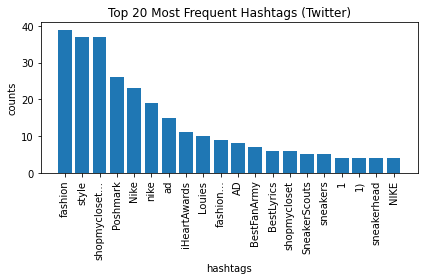

[('fashion', 39), ('style', 37), ('shopmycloset…', 37), ('Poshmark', 26), ('Nike', 23), ('nike', 19), ('ad', 15), ('iHeartAwards', 11), ('Louies', 10), ('fashion…', 9), ('AD', 8), ('BestFanArmy', 7), ('BestLyrics', 6), ('shopmycloset', 6), ('SneakerScouts', 5), ('sneakers', 5), ('1', 4), ('1)', 4), ('sneakerhead', 4), ('NIKE', 4)]


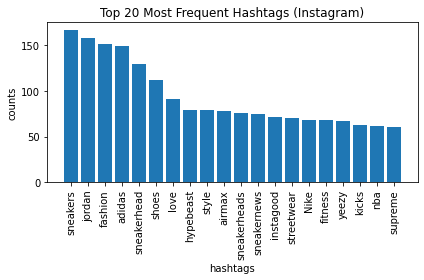

[('sneakers', 167), ('jordan', 158), ('fashion', 152), ('adidas', 149), ('sneakerhead', 130), ('shoes', 112), ('love', 91), ('hypebeast', 79), ('style', 79), ('airmax', 78), ('sneakerheads', 76), ('sneakernews', 75), ('instagood', 71), ('streetwear', 70), ('Nike', 68), ('fitness', 68), ('yeezy', 67), ('kicks', 63), ('nba', 62), ('supreme', 61)]


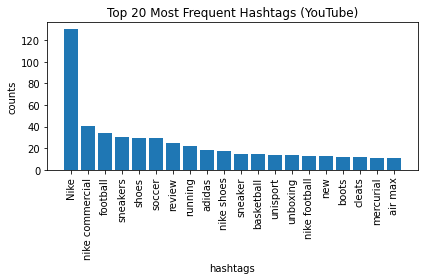

[('Nike', 130), ('nike commercial', 41), ('football', 34), ('sneakers', 30), ('shoes', 29), ('soccer', 29), ('review', 25), ('running', 22), ('adidas', 18), ('nike shoes', 17), ('sneaker', 15), ('basketball', 15), ('unisport', 14), ('unboxing', 14), ('nike football', 13), ('new', 13), ('boots', 12), ('cleats', 12), ('mercurial', 11), ('air max', 11)]


In [18]:
get_most_freq_hashtag(df_lst[1:], title_lst[1:])

#### Sensitive Scores

In [14]:
# Function used to process captions by lemmatization and removing punctuations and most/least frequent words
# return the processed captions as pandas series
def processTextCalculateSentiment(df):
    # Remove all hashtags, punctuations, and stopwords
    captions = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    captions = captions.apply(lambda x: ' '.join(re.sub("(#[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x) for x in x.split()))
    captions = captions.apply(lambda x: " ".join(x for x in x.split() if x not in nltk.corpus.stopwords.words('english')))
    
    # Remove most 10 common words
    freq = pd.Series(' '.join(captions).split()).value_counts()[:10]
    captions = captions.apply(lambda x: " ".join(x for x in x.split() if x not in list(freq.index)))
    # Remove 10 least frequent words
    least_freq = pd.Series(' '.join(captions).split()).value_counts()[-10:]
    captions = captions.apply(lambda x: " ".join(x for x in x.split() if x not in list(freq.index)))

    # Lemmatization
    captions = captions.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    captions.replace('', np.nan, inplace=True)
    captions.dropna(inplace=True)
    
    df['fully_proccessed_tokens'] = captions
    df['sentiment_score'] = df['fully_proccessed_tokens'].apply(lambda x: sentiment_score(str(x)))
    return df

# Function used to compute sentimental score from the input
def sentiment_score(text):
    sid = nltk.sentiment.vader.SentimentIntensityAnalyzer()
    return sid.polarity_scores(text)['compound']

In [15]:
def plotSentimentDistribution(df_list, title_list):
    for i in range(len(df_list)):
        df_list[i] = processTextCalculateSentiment(df_list[i])
        df_list[i]['sentiment_score'].hist()
        plt.xlabel('sentiment score')
        plt.ylabel('counts')
        plt.title('Sentiment Scores for ' + title_list[i])
        print('Average Sentiment Score for ' + title_list[i] + ' is ' + 
              str(df_list[i]['sentiment_score'].sum()/df_list[i].shape[0]))
        plt.show()

Average Sentiment Score for Reddit is 0.15739721362229103


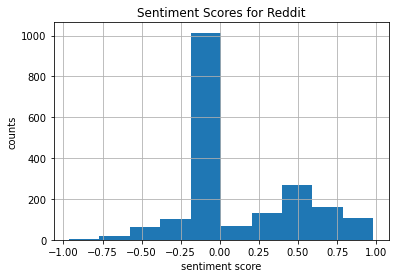

Average Sentiment Score for Twitter is 0.10932519120458892


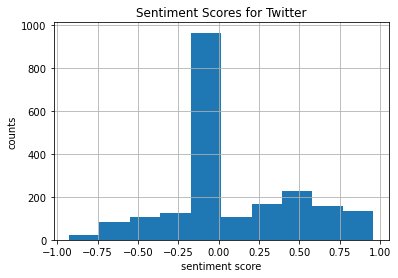

Average Sentiment Score for Instagram is 0.18563516579406633


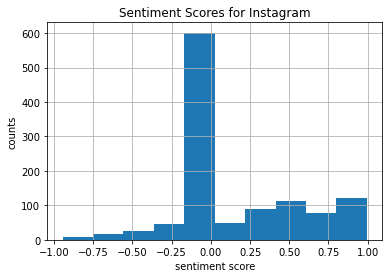

Average Sentiment Score for YouTube is 0.8755456647398844


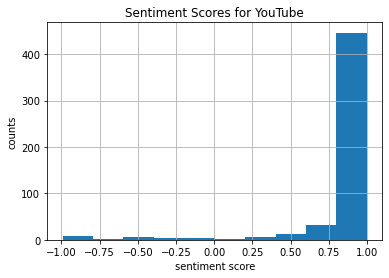

In [16]:
plotSentimentDistribution(df_lst, title_lst)

#### Word Frequency Distribution

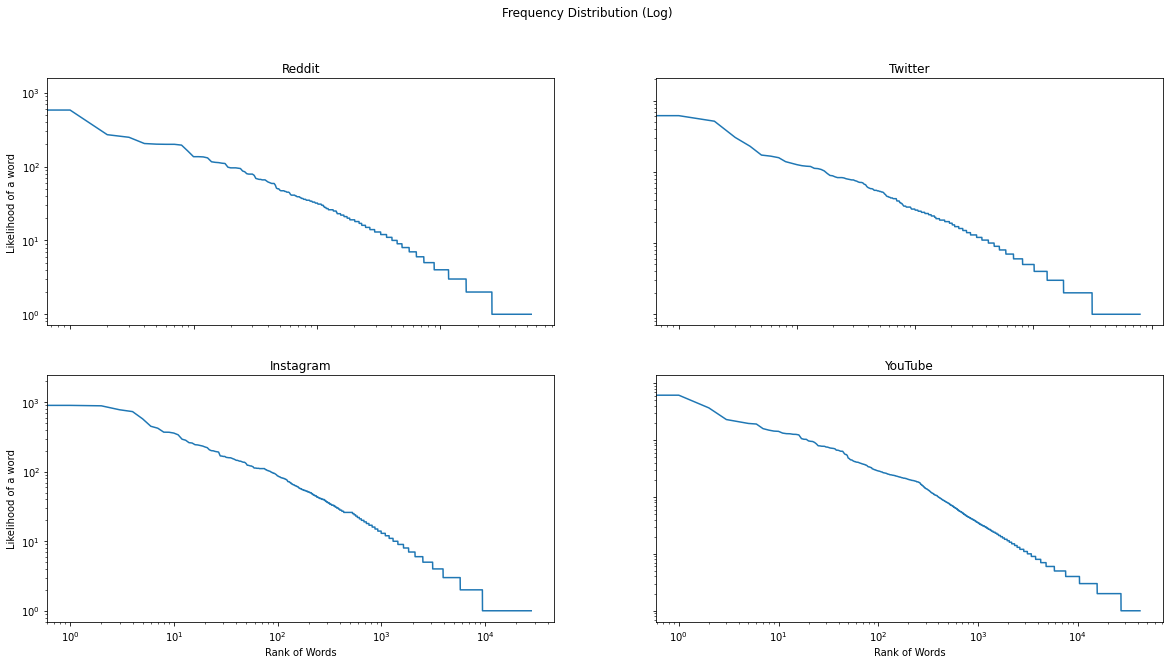

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle("Frequency Distribution (Log)")

axs[0, 0].plot(range(len(wordsCount_rdt)), wordsCount_rdt['count'])
axs[0, 0].set_title("Reddit")
axs[0, 1].plot(range(len(wordsCount_twt)), wordsCount_twt['count'])
axs[0, 1].set_title("Twitter")

axs[1, 0].plot(range(len(wordsCount_ins)), wordsCount_ins['count'])
axs[1, 0].set_title("Instagram")
axs[1, 1].plot(range(len(wordsCount_ytb)), wordsCount_ytb['count'])
axs[1, 1].set_title("YouTube")

for ax in axs.flat:
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set(xlabel='Rank of Words', ylabel='Likelihood of a word')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# set the spacing between subplots 
plt.show()

### Word Concordance

In [17]:
text = nltk.Text(token_twt) #Convert t_data into a Text class of nltk
CIndex = nltk.text.ConcordanceIndex(text) #Load the text into a ConcordanceIndex

In [18]:
# The surrounding words of 'enjoy'
CIndex.print_concordance('best')

Displaying 21 of 21 matches:
Colorways RT @kicksonfire Here ’s our best look yet at the upcoming Travis Scott
e gear by @ClubsportNI 🔥 No doubt the best looking kit in the league Link ⏬ to L
er with the new Nike RT @SoobinAlmond best model I think @Nike @TXT_members @Nik
lue is the AMBUSH x Nike Dunk High 's best colorway yet 😤 Who agrees gt;&gt @lov
ves the Palestine state national flag best model I think @Nike @TXT_members @AJK
 tee and nike cortez ’s 🙄 I love this best from Nike so far COYS RT @Shirteta @s
l all Adidas are doing is copying the best Nike kits Arsenal had amp they ’re be
some pairs for me Please make May the best m 👀 Nooooo hey Nike hates this club R
04verse 🦊 instead of trying to be the best i think that if i try to be someone w
 wish y all would stop making all the best colors in women 's Gray and black are
some of whom ar Nike Always gives its best for PSG amp the worst for Barça Hence
unty Nike RT @kicksonfire Here ’s our best look yet at the upcoming Travis Scott

In [19]:
text.common_contexts(['fit'])

this_all size_l dri_medium hoes_tighter dri_size favorite_and
dri_running dri_cotton sizes_up never_you dri_tempo angels_me a_that
dri_mvp dri_sports dri_womens


In [25]:
text = nltk.Text(token_rdt)
num_strong_pos = text.count('love') + text.count('best')
num_strong_neg = text.count('hate') + text.count('worst')
num_weak_pos = text.count('like') + text.count('good')
total_words_count = reddit['word_counts'].sum()
print(num_strong_pos/total_words_count)
print(num_strong_neg/total_words_count)
print(num_weak_pos/total_words_count)

0.0021292093909340507
8.404773911581779e-05
0.004090323303636466


In [30]:
# Make a plot to show each time a set of words occurs
list_of_words = ['love', 'hate', 'like', 'fit', 'worst', 'best', 'good']
token_lst = [token_rdt, token_twt, token_ins, token_ytb]
def plotWordsOccurance(token_list, title_list, df_list):
    for i in range(len(token_list)):
        text = nltk.Text(token_list[i])
        sns.reset_orig()
        nltk.draw.dispersion.dispersion_plot(text, list_of_words, 
                                             title="Word Occurances in {}".format(title_list[i]))
        sns.set()
        
        num_strong_pos = text.count('love') + text.count('best')
        num_strong_neg = text.count('hate') + text.count('worst')
        num_weak_pos = text.count('like') + text.count('good')
        total_words_count = df_list[i]['word_counts'].sum()
        print('Frequency Strong Positive Words: ' + str(num_strong_pos/total_words_count))
        print('Frequency Strong Negative Words: ' + str(num_strong_neg/total_words_count))
        print('Frequency Weak Positive Words: ' + str(num_weak_pos/total_words_count))
        print('Frequency Emotion Words: ' + str((num_weak_pos+num_strong_pos+num_strong_neg)/total_words_count))

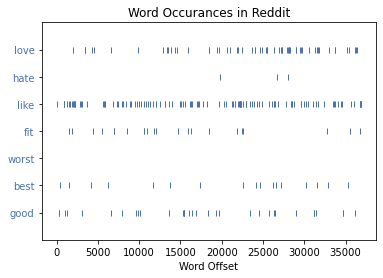

Frequency Strong Positive Words: 0.0021292093909340507
Frequency Strong Negative Words: 8.404773911581779e-05
Frequency Weak Positive Words: 0.004090323303636466
Frequency Emotion Words: 0.006303580433686334


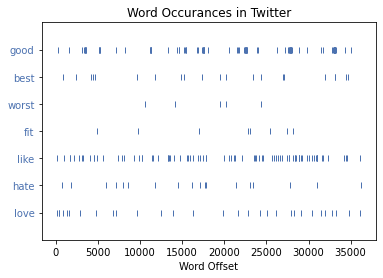

Frequency Strong Positive Words: 0.001499867658735994
Frequency Strong Negative Words: 0.0006764109049201541
Frequency Weak Positive Words: 0.00502896803223245
Frequency Emotion Words: 0.007205246595888598


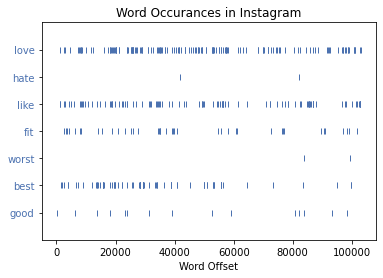

Frequency Strong Positive Words: 0.004686941717984825
Frequency Strong Negative Words: 8.407070346161121e-05
Frequency Weak Positive Words: 0.002353979696925114
Frequency Emotion Words: 0.0071249921183715505


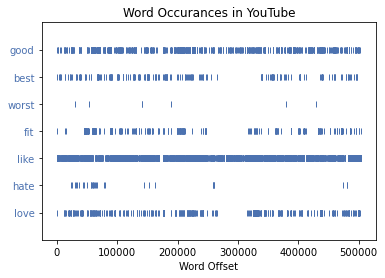

Frequency Strong Positive Words: 0.0011844086586819931
Frequency Strong Negative Words: 7.340556176086055e-05
Frequency Weak Positive Words: 0.008721374310830891
Frequency Emotion Words: 0.009979188531273745


In [31]:
plotWordsOccurance(token_lst, title_lst, df_lst)

#### Word Distribution

#### (1) word frequency distribution (word lengths)

In [29]:
def wordDistributionLength(df_list, title_list, word_length, num_words=20):
    for i in range(len(df_list)):
        whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in df_list[i]['normalized_tokens'].sum()))
        whcfdist[word_length].plot(num_words, title=title_list[i])

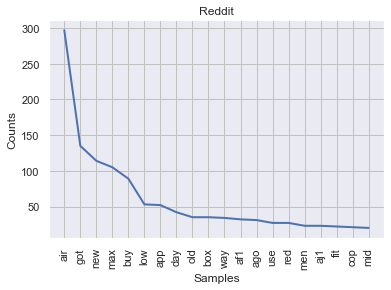

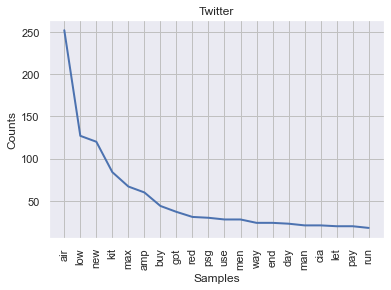

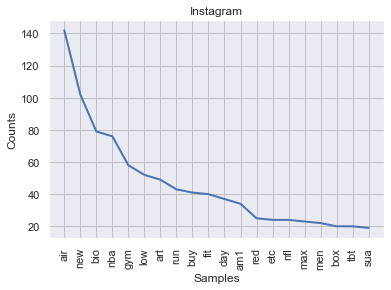

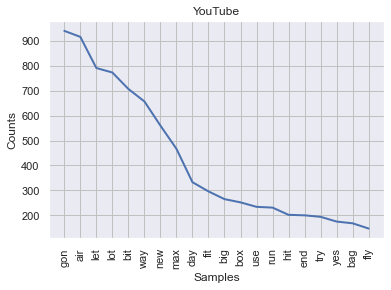

In [30]:
wordDistributionLength(df_lst, title_lst, 3)

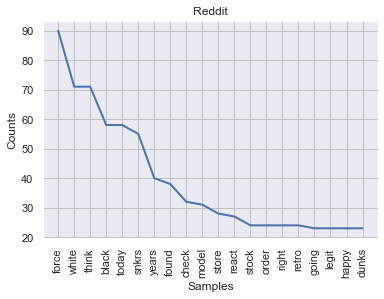

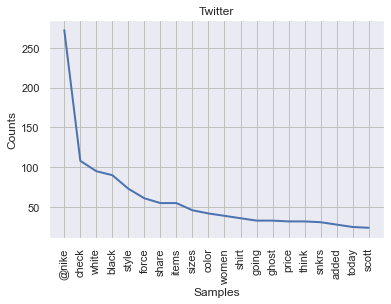

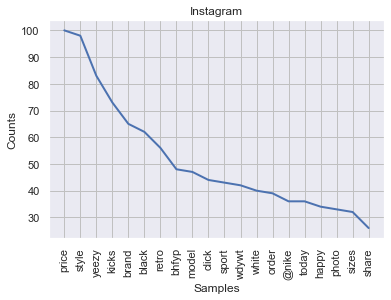

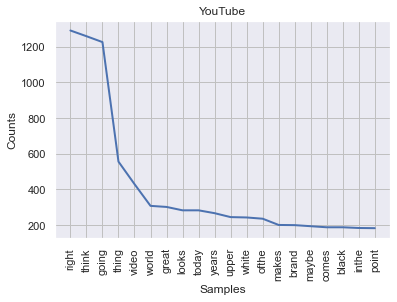

In [31]:
wordDistributionLength(df_lst, title_lst, 5)

#### (2) word frequency distribution (POS)

In [32]:
def wordDistributionPOS(df_list, title_list, pos, num_words=20):
    freqDict = {}
    for i in range(len(df_list)):
        df_list[i]['normalized_tokens_POS'] = [nltk.pos_tag(t) for t in df_list[i]['normalized_tokens']]
        POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in df_list[i]['normalized_tokens_POS'].sum())
        POStoWord[pos].plot(num_words, title=title_list[i])
        freqDict[title_list[i]] = POStoWord[pos].most_common(10)
    return pd.DataFrame(freqDict)

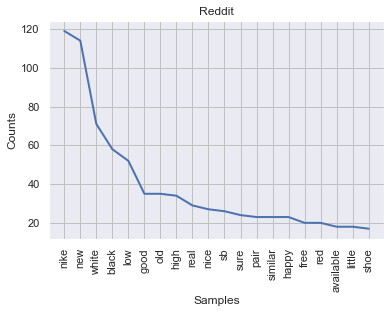

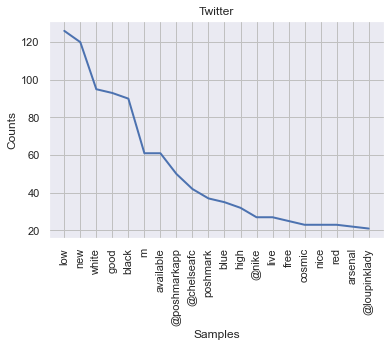

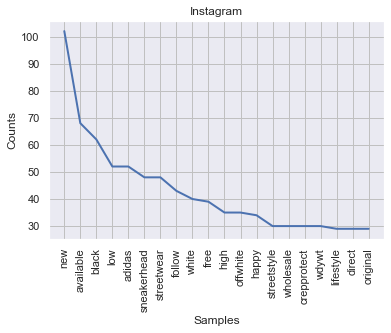

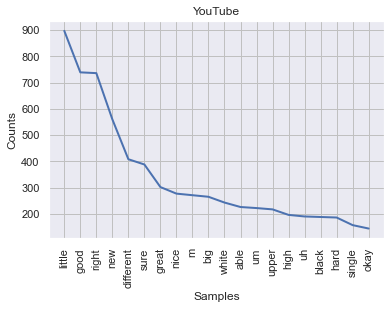

,Reddit,Twitter,Instagram,YouTube
0,"(nike, 119)","(low, 126)","(new, 102)","(little, 897)"
1,"(new, 114)","(new, 120)","(available, 68)","(good, 739)"
2,"(white, 71)","(white, 95)","(black, 62)","(right, 736)"
3,"(black, 58)","(good, 93)","(low, 52)","(new, 560)"
4,"(low, 52)","(black, 90)","(adidas, 52)","(different, 408)"
5,"(good, 35)","(m, 61)","(sneakerhead, 48)","(sure, 388)"
6,"(old, 35)","(available, 61)","(streetwear, 48)","(great, 302)"
7,"(high, 34)","(@poshmarkapp, 50)","(follow, 43)","(nice, 277)"
8,"(real, 29)","(@chelseafc, 42)","(white, 40)","(m, 271)"
9,"(nice, 27)","(poshmark, 37)","(free, 39)","(big, 265)"


In [33]:
wordDistributionPOS(df_lst, title_lst, 'JJ')

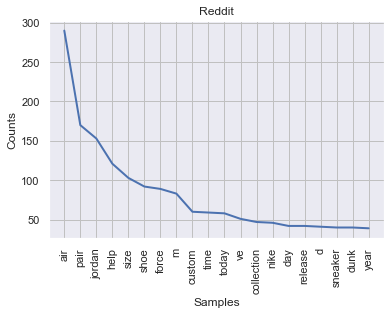

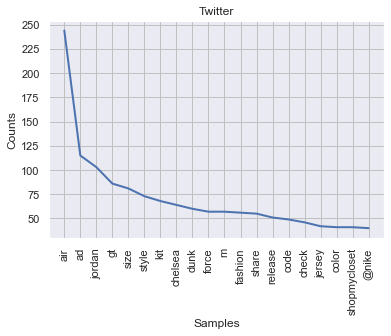

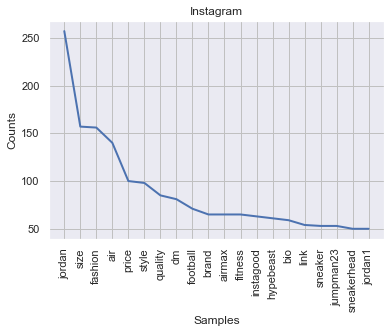

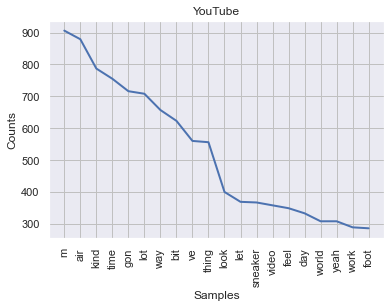

,Reddit,Twitter,Instagram,YouTube
0,"(air, 290)","(air, 244)","(jordan, 257)","(m, 906)"
1,"(pair, 170)","(ad, 115)","(size, 157)","(air, 879)"
2,"(jordan, 153)","(jordan, 103)","(fashion, 156)","(kind, 787)"
3,"(help, 121)","(gt, 86)","(air, 140)","(time, 755)"
4,"(size, 103)","(size, 81)","(price, 100)","(gon, 716)"
5,"(shoe, 92)","(style, 73)","(style, 98)","(lot, 708)"
6,"(force, 89)","(kit, 68)","(quality, 85)","(way, 657)"
7,"(m, 83)","(chelsea, 64)","(dm, 81)","(bit, 623)"
8,"(custom, 60)","(dunk, 60)","(football, 71)","(ve, 560)"
9,"(time, 59)","(force, 57)","(brand, 65)","(thing, 556)"


In [34]:
wordDistributionPOS(df_lst, title_lst, 'NN')

#### (3) conditional probability distribution (word length)

In [35]:
def wordProbDistribLength(df_list, title_list, word_length):
    most_common = {}
    for i in range(len(df_list)):
        whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in df_list[i]['normalized_tokens'].sum()))
        whcpdist = nltk.ConditionalProbDist(whcfdist, nltk.ELEProbDist)
        most_common_word = whcpdist[word_length].max()
        most_common[title_list[i]] = [most_common_word, whcpdist[word_length].prob(most_common_word)]
    return pd.DataFrame(most_common)

In [36]:
wordProbDistribLength(df_lst, title_lst, 5)

,Reddit,Twitter,Instagram,YouTube
0,force,@nike,price,right
1,0.0328136,0.0764805,0.0235805,0.0380592


In [37]:
wordProbDistribLength(df_lst, title_lst, 6)

,Reddit,Twitter,Instagram,YouTube
0,jordan,jordan,jordan,little
1,0.0660678,0.045203,0.0738271,0.0291335


#### (4) conditional probability distribution (POS)

In [38]:
def wordProbDistribPOS(df_list, title_list, pos):
    most_common = {}
    for i in range(len(df_list)):
        df_list[i]['normalized_tokens_POS'] = [nltk.pos_tag(t) for t in df_list[i]['normalized_tokens']]
        POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in df_list[i]['normalized_tokens_POS'].sum())
        whcpdist_POStoWord = nltk.ConditionalProbDist(POStoWord, nltk.ELEProbDist)
        most_common_word = whcpdist_POStoWord[pos].max()
        most_common[title_list[i]] = [most_common_word, whcpdist_POStoWord[pos].prob(most_common_word)]
    return pd.DataFrame(most_common)

In [39]:
wordProbDistribPOS(df_lst, title_lst, 'JJ')

,Reddit,Twitter,Instagram,YouTube
0,nike,low,new,little
1,0.0353446,0.029601,0.0142728,0.0174157


In [40]:
wordProbDistribPOS(df_lst, title_lst, 'NN')

,Reddit,Twitter,Instagram,YouTube
0,air,air,jordan,m
1,0.0358731,0.0252465,0.0138878,0.00987607


#### (5) Word Cloud

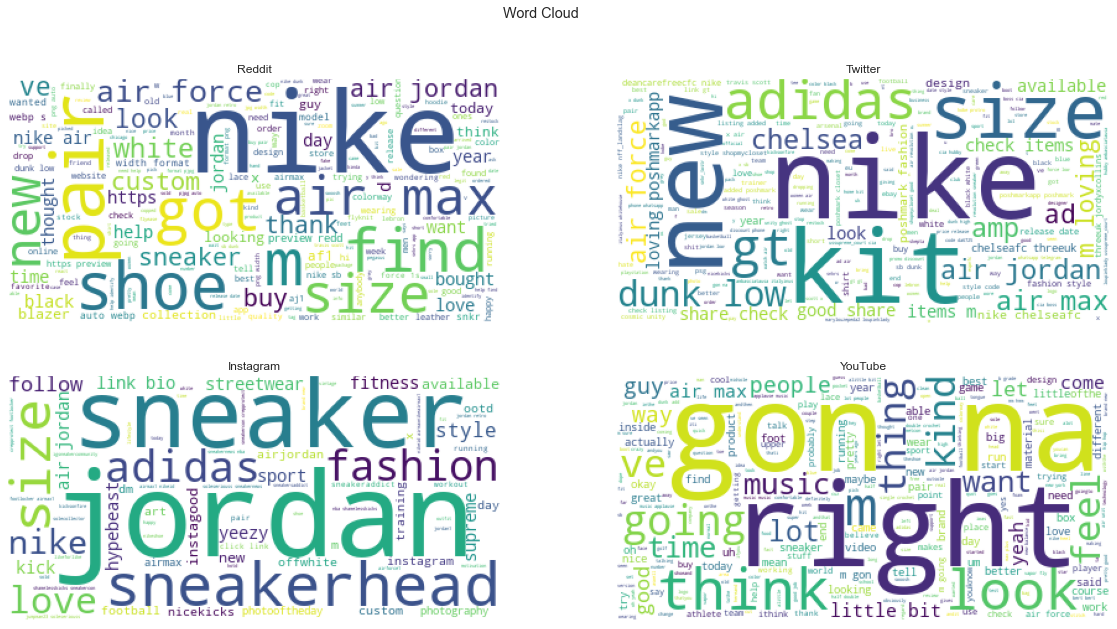

In [41]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle("Word Cloud")

wc_1 = wordcloud.WordCloud(background_color="white", max_words=500, mode='RGBA').generate(' '.join(reddit['normalized_tokens'].sum()))
axs[0, 0].imshow(wc_1)
axs[0, 0].set_title("Reddit")
wc_2 = wordcloud.WordCloud(background_color="white", max_words=500, mode='RGBA').generate(' '.join(twitter['normalized_tokens'].sum()))
axs[0, 1].imshow(wc_2)
axs[0, 1].set_title("Twitter")

wc_3 = wordcloud.WordCloud(background_color="white", max_words=500, mode='RGBA').generate(' '.join(ins['normalized_tokens'].sum()))
axs[1, 0].imshow(wc_3)
axs[1, 0].set_title("Instagram")
wc_4 = wordcloud.WordCloud(background_color="white", max_words=500, mode='RGBA').generate(' '.join(youtube['normalized_tokens'].sum()))
axs[1, 1].imshow(wc_4)
axs[1, 1].set_title("YouTube")

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

#### Bigrams

In [42]:
def bigrams(df_list, title_list):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    bigram_dict = {}
    for i in range(len(df_list)):
        bigrams = nltk.collocations.BigramCollocationFinder.from_words(df_list[i]['normalized_tokens'].sum())
        bigram_dict[title_list[i]] = bigrams.score_ngrams(bigram_measures.student_t)[:10]
    return pd.DataFrame(bigram_dict)

In [43]:
bigrams(df_lst, title_lst)

,Reddit,Twitter,Instagram,YouTube
0,"((air, max), 9.709874716893006)","((dunk, low), 8.230908396277801)","((⠀, ⠀), 10.205413217110722)","((gon, na), 30.52517212820035)"
1,"((air, force), 8.989597179172858)","((air, max), 8.078945297097528)","((❤, ❤), 8.755483789779907)","((air, max), 18.521756849502633)"
2,"((air, jordan), 6.991931043398816)","((air, jordan), 7.991595877506175)","((╌, ╌), 8.107815883153535)","((little, bit), 18.495644502630697)"
3,"((nike, air), 6.459746908757954)","((air, force), 7.57790798982903)","((air, jordan), 7.971626435320928)","((m, gon), 13.60731257349558)"
4,"((dunk, low), 4.43718098878296)","((m, loving), 7.295959603851732)","((link, bio), 7.592514147694514)","((m, going), 9.778473725791464)"
5,"((force, 1s), 4.434583257369865)","((loving, @poshmarkapp), 7.2571160780856)","((🔥, 🔥), 6.814087652155614)","((air, force), 9.54176636375212)"
6,"((nike, sb), 4.425406743225382)","((good, share), 7.243865407227511)","((click, link), 6.229200164760714)","((alittle, bit), 9.012787436615657)"
7,"((sb, dunk), 4.3352158048187075)","((check, items), 7.238019523025414)","((brand, new), 5.712614276739101)","((air, jordan), 8.770496019083556)"
8,"((y, think), 4.329484899530303)","((share, check), 7.238019523025414)","((jordan, retro), 5.570533393989745)","((lot, people), 8.303591582331835)"
9,"((jordan, retro), 4.300567994291938)","((items, m), 7.227107205848164)","((🏆, 🏆), 5.559809525923646)","((half, double), 6.913908020952652)"


#### Trigrams

In [44]:
def trigrams(df_list, title_list):
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    trigram_dict = {}
    for i in range(len(df_list)):
        trigrams = nltk.collocations.TrigramCollocationFinder.from_words(df_list[i]['normalized_tokens'].sum())
        trigram_dict[title_list[i]] = trigrams.score_ngrams(trigram_measures.student_t)[:10]
    return pd.DataFrame(trigram_dict)

In [45]:
trigrams(df_lst, title_lst)

,Reddit,Twitter,Instagram,YouTube
0,"((nike, air, max), 5.085945318659719)","((share, check, items), 7.279990468586991)","((⠀, ⠀, ⠀), 9.79780985874401)","((m, gon, na), 14.069215865136021)"
1,"((air, force, 1s), 4.4714646041781725)","((items, m, loving), 7.2799595076664465)","((❤, ❤, ❤), 8.484938533963152)","((air, max, plus), 5.098874237536567)"
2,"((nike, sb, dunk), 4.122216433620805)","((m, loving, @poshmarkapp), 7.279948570821787)","((╌, ╌, ╌), 7.9372222184442345)","((bert, bert, bert), 4.9999992886204)"
3,"((nike, air, force), 3.72638556586747)","((good, share, check), 7.27990795974419)","((click, link, bio), 6.244963450886775)","((half, double, crochet), 4.898969296751138)"
4,"((sb, dunk, low), 3.3165254907503257)","((check, items, m), 7.279814594474705)","((nikeid, airmaxnikeairmax1, kissmyairs), 5.47...","((air, force, ones), 4.242536371100769)"
5,"((x, air, jordan), 3.1589236759559984)","((@nike, @chelseafc, @threeuk), 6.707654925174...","((airmaxnikeairmax1, kissmyairs, am1), 5.47722...","((|, playlist, |), 3.999989755957391)"
6,"((jordan, retro, high), 2.8282431485213646)","((@deancarefreecfc, @nike, @chelseafc), 6.5569...","((airmax1, nikeid, airmaxnikeairmax1), 5.47722...","((half, double, crochets), 3.7416502882707046)"
7,"((air, jordan, retro), 2.8268200383116877)","((@chelseafc, @threeuk, @jordyxcollins), 6.324...","((wdywt, am1lover, am1collector), 5.4772202867...","((95and, air, max), 3.7416231683726937)"
8,"((custom, air, force), 2.8262014013461334)","((poshmark, fashion, style), 6.164281645412286)","((shamelesskicks, sneakercon, crepprotect), 5....","((air, max, 95and), 3.7416231683726937)"
9,"((🔥, 🔥, 🔥), 2.645609127818969)","((fashion, style, shopmycloset), 6.08268562666...","((footlocker, airmax1, nikeid), 5.477219699171...","((max, 95and, air), 3.7416231683726937)"


#### KL Divergence

In [46]:
rdt_words = set(reddit['normalized_tokens'].sum())
twt_words = set(twitter['normalized_tokens'].sum())
ins_words = set(ins['normalized_tokens'].sum())
ytb_words = set(youtube['normalized_tokens'].sum())

overlapWords = rdt_words & twt_words & ins_words & ytb_words
overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}

In [47]:
def makeProbsArray(dfColumn, overlapDict):
    words = dfColumn.sum()
    countList = [0] * len(overlapDict)
    for word in words:
        try:
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

rdtProbArray = makeProbsArray(reddit['normalized_tokens'], overlapWordsDict)
twtProbArray = makeProbsArray(twitter['normalized_tokens'], overlapWordsDict)
insProbArray = makeProbsArray(ins['normalized_tokens'], overlapWordsDict)
ytbProbArray = makeProbsArray(youtube['normalized_tokens'], overlapWordsDict)

In [48]:
# Calculate divergences
rdt_twt_divergence = scipy.stats.entropy(rdtProbArray, twtProbArray)
print("Reddit & Twitter: {}".format(rdt_twt_divergence))
rdt_ins_divergence = scipy.stats.entropy(rdtProbArray, insProbArray)
print("Reddit & Instagra: {}".format(rdt_ins_divergence))
rdt_ytb_divergence = scipy.stats.entropy(rdtProbArray, ytbProbArray)
print("Reddit & YouTube: {}".format(rdt_ytb_divergence))

twt_ins_divergence = scipy.stats.entropy(twtProbArray, insProbArray)
print("Twitter & Instagram: {}".format(twt_ins_divergence))
twt_ytb_divergence = scipy.stats.entropy(twtProbArray, ytbProbArray)
print("Twitter & YouTube: {}".format(twt_ytb_divergence))
ins_ytb_divergence = scipy.stats.entropy(insProbArray, ytbProbArray)
print("Instagram & YouTube: {}".format(ins_ytb_divergence))

Reddit & Twitter: 0.5613982330337757
Reddit & Instagra: 0.7612649157786531
Reddit & YouTube: 0.7292259034781612
Twitter & Instagram: 0.6592197963402131
Twitter & YouTube: 0.9942570570994582
Instagram & YouTube: 1.2927888559569545


In [49]:
from IPython.display import display

# Elementwise calculation and see which words best distinguish the two corpora
def wordMostDistinguish(probArray_list, title_list, num_words=10):
    kl_df = pd.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
    kl_df = kl_df.sort_index()
    for i in range(len(probArray_list)):
        print(title_list[i])
        result = {}
        for j in range(len(probArray_list)):
            if (probArray_list[j] != probArray_list[i]).all():
                divergence_ew = scipy.special.kl_div(probArray_list[j], probArray_list[i])
                wd_df = kl_df
                wd_df['elementwise divergence'] = divergence_ew
                wd_df = wd_df.sort_values(by='elementwise divergence', ascending=False)[:num_words]
                wd_df[" vs. " + title_list[j]] = wd_df['word'] + ", " + wd_df['elementwise divergence'].astype(str)
                wd_df.drop(columns=['word', 'elementwise divergence'], inplace=True)
                wd_df.reset_index(drop=True, inplace=True)
                result.update(wd_df.to_dict())
        display(pd.DataFrame.from_dict(result))

In [50]:
probArray_lst = [rdtProbArray, twtProbArray, insProbArray, ytbProbArray]
wordMostDistinguish(probArray_lst, title_lst)

Reddit


,vs. Twitter,vs. Instagram,vs. YouTube
0,"kit, 0.03411019655711224","fashion, 0.05049643007337988","yeah, 0.028350784960505748"
1,"ad, 0.032865601948675854","adidas, 0.04325430466569292","right, 0.017639024444962674"
2,"gt, 0.032471686856303056","dm, 0.037895606785939645","okay, 0.0173815188807698"
3,"adidas, 0.017399197826281226","follow, 0.030470754115147113","going, 0.01662839476417137"
4,"fashion, 0.015840163186390074","sneakerhead, 0.030385365083353773","na, 0.015367659079925274"
5,"pair, 0.013053624572635033","nba, 0.01937660868250126","gon, 0.01517473133848904"
6,"items, 0.012999523807946176","sneakers, 0.018159369631827814","lot, 0.012880435963861344"
7,"find, 0.01155285613645336","football, 0.017644164956492375","let, 0.011889799885936856"
8,"jersey, 0.010911455628183447","offwhite, 0.015574760933418941","pair, 0.010627171050340467"
9,"help, 0.008175443775104053","bags, 0.014810347609507302","little, 0.010271051571521934"


Twitter


,vs. Reddit,vs. Instagram,vs. YouTube
0,"find, 0.0311873474685092","sneakerhead, 0.02669778383314389","right, 0.026279311711007617"
1,"pair, 0.02611393596778588","sneakerheads, 0.024432402725409332","little, 0.024220853930367804"
2,"help, 0.01548627345589723","airmax, 0.020651272671127836","kind, 0.01788142619694765"
3,"ad, 0.01132020523745773","supreme, 0.019223776709676607","lot, 0.017396587604742088"
4,"came, 0.009972147154319008","yeezy, 0.015617122860737681","bit, 0.015156003842352965"
5,"gt, 0.00984623387053565","bags, 0.014270403425449446","okay, 0.013997374532806637"
6,"thanks, 0.009248432145610828","dm, 0.012102891151285843","gon, 0.0132985537569651"
7,"kit, 0.009039402854457961","sneakers, 0.011764190804536582","feel, 0.012095805621010203"
8,"thoughts, 0.007094941663471524","offwhite, 0.011478051570357193","think, 0.011614974707242421"
9,"adidas, 0.007051383421315535","ad, 0.011391059113991889","x, 0.011188336887543495"


Instagram


,vs. Reddit,vs. Twitter,vs. YouTube
0,"help, 0.030882312642717995","gt, 0.04044658646974092","gon, 0.04644635993448729"
1,"find, 0.024145541815493072","ad, 0.0335122341808623","going, 0.03254975653873107"
2,"pair, 0.023173516563544404","check, 0.015465680422964383","think, 0.030407763382207933"
3,"adidas, 0.014754298198425733","kit, 0.014262128914629713","kind, 0.030160801251162956"
4,"fashion, 0.01412345695375498","good, 0.011341252931445996","yeah, 0.02876751555182187"
5,"sneakerhead, 0.011080599804824207","sneakerhead, 0.010543271466979271","right, 0.023420897618870392"
6,"wanted, 0.010956800561740537","items, 0.010284822058976338","okay, 0.02236826801414196"
7,"thoughts, 0.010200096833514983","m, 0.008770163076043455","lot, 0.020605954343408305"
8,"follow, 0.010084330694222713","added, 0.008077390178312329","jordan, 0.020311705389155894"
9,"sneakers, 0.009971768688162796","closet, 0.007680084572214375","actually, 0.019349406188983006"


YouTube


,vs. Reddit,vs. Twitter,vs. Instagram
0,"snkrs, 0.024782721366380676","gt, 0.039838299574340826","dm, 0.05222280481515512"
1,"pair, 0.018673462106853594","ad, 0.031651689353858405","sneakerhead, 0.0483092889195912"
2,"jordan, 0.016451409404723286","x, 0.02636237051253183","fashion, 0.04259156935531814"
3,"af1, 0.01491442393565015","kit, 0.025886319633575343","jordan, 0.04207687700840282"
4,"help, 0.013134882627365497","$, 0.0247872933773776","sneakerheads, 0.028740872447317708"
5,"d, 0.010979454880277744","low, 0.021045353480124734","adidas, 0.02813891203773161"
6,"custom, 0.01076061738553891","items, 0.0177049369669685","$, 0.02241191330591581"
7,"app, 0.010375467430840906","code, 0.016240436649887162","yeezy, 0.0218097554664858"
8,"air, 0.01021041729795339","snkrs, 0.013936581144635913","follow, 0.020878266963099967"
9,"find, 0.010060190859087709","fashion, 0.012594612532378745","sneakers, 0.0207010020757007"


In [33]:
# Functions to calculate divergence and distances.
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pd.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pd.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

#### KL Distance

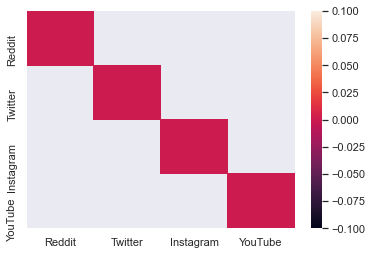

In [52]:
# Plot KL distances heatmap
L = []
for p in df_lst:
    l = []
    for q in df_lst:
        l.append(Divergence(p['text'],q['text'], difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = title_lst, index = title_lst)
ax = sns.heatmap(div)
plt.show()

#### $\chi^2$ Distance

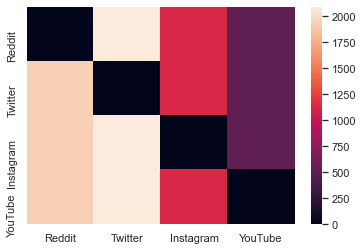

In [53]:
L = []
for p in df_lst:
    l = []
    for q in df_lst:
        l.append(Divergence(p['text'],q['text'], difference='Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = title_lst, index = title_lst)
ax = sns.heatmap(div)
plt.show()

#### KS Distance

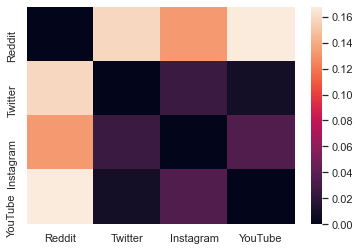

In [54]:
L = []
for p in df_lst:
    l = []
    for q in df_lst:
        l.append(Divergence(p['text'],q['text'], difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = title_lst, index = title_lst)
ax = sns.heatmap(div)
plt.show()

#### Wasserstein Distance

             Reddit   Twitter  Instagram   YouTube
Reddit     0.000000  0.205189   0.192035  0.202233
Twitter    0.205189  0.000000   0.085745  0.030542
Instagram  0.192035  0.085745   0.000000  0.109390
YouTube    0.202233  0.030542   0.109390  0.000000


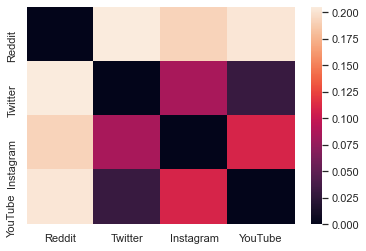

In [34]:
L = []
for p in df_lst:
    l = []
    for q in df_lst:
        l.append(Divergence(p['text'],q['text'], difference='Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = title_lst, index = title_lst)
print(div)
ax = sns.heatmap(div)
plt.show()

#### Multidimensional Scaling

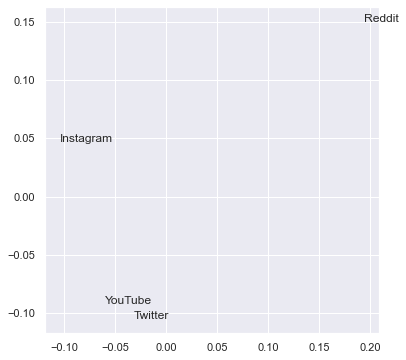

In [56]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(title_lst):
    ax.annotate(txt, (x[i],y[i]))

#### Jensen-Shannon Divergence

In [57]:
# Calculate Jensen-Shannon Divergences
rdt_twt_JSD = scipy.spatial.distance.jensenshannon(rdtProbArray, twtProbArray)
print("Reddit & Twitter: {}".format(rdt_twt_JSD))
rdt_ins_JSD = scipy.spatial.distance.jensenshannon(rdtProbArray, insProbArray)
print("Reddit & Instagram: {}".format(rdt_ins_JSD))
rdt_ytb_JSD = scipy.spatial.distance.jensenshannon(rdtProbArray, ytbProbArray)
print("Reddit & YouTube: {}\n".format(rdt_ytb_JSD))

twt_ins_JSD = scipy.spatial.distance.jensenshannon(twtProbArray, insProbArray)
print("Twitter & Instagram: {}".format(twt_ins_JSD))
twt_ytb_JSD = scipy.spatial.distance.jensenshannon(twtProbArray, ytbProbArray)
print("Twitter & YouTube: {}".format(twt_ytb_JSD))
ins_ytb_JSD = scipy.spatial.distance.jensenshannon(insProbArray, ytbProbArray)
print("Instagram & YouTube: {}\n".format(ins_ytb_JSD))

Reddit & Twitter: 0.3499843783621317
Reddit & Instagram: 0.4096228421966445
Reddit & YouTube: 0.38265292103425286

Twitter & Instagram: 0.3742562418256319
Twitter & YouTube: 0.433692324240031
Instagram & YouTube: 0.484939203378277



## Discovering Patterns: Clusters & Topics 

#### Selecting Cluster Number

In [58]:
def getTFVects(df):
    TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.50, max_features=1000, 
                                                           min_df=3, stop_words='english', norm='l2')
    TFVects = TFVectorizer.fit_transform(df['text'])
    return TFVectorizer, TFVects

In [59]:
from sklearn.cluster import KMeans
def plotSilhouette_revised(n_clusters, X, reduced_data):
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

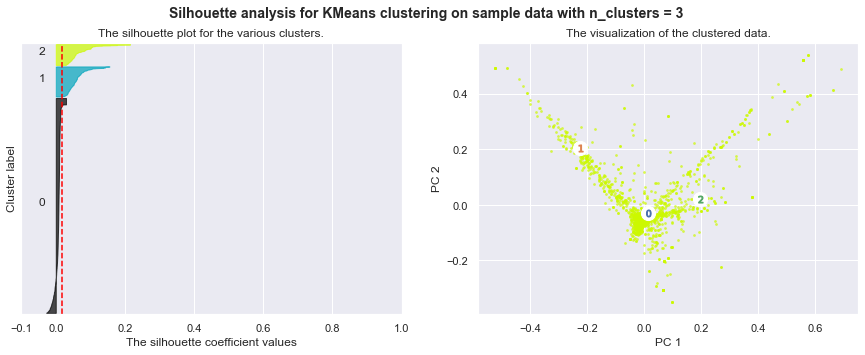

For n_clusters = 3, The average silhouette_score is : 0.018


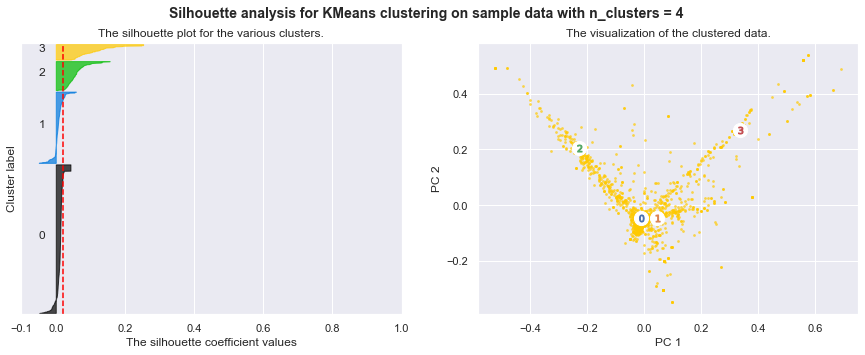

For n_clusters = 4, The average silhouette_score is : 0.021


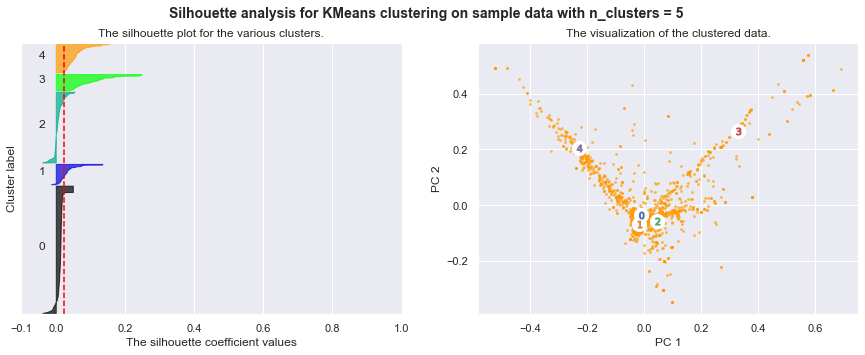

For n_clusters = 5, The average silhouette_score is : 0.023


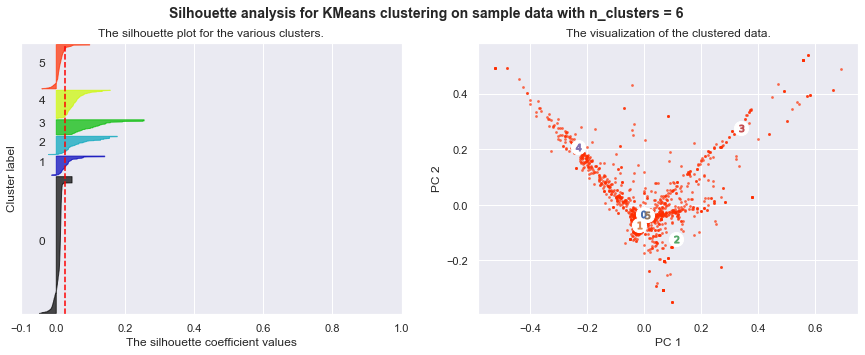

For n_clusters = 6, The average silhouette_score is : 0.027


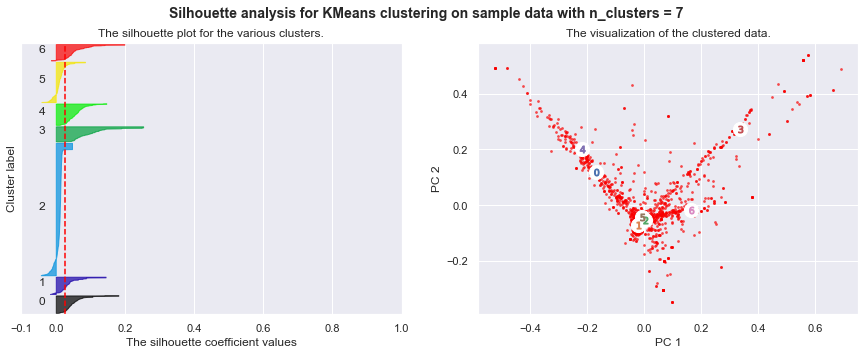

For n_clusters = 7, The average silhouette_score is : 0.027


In [60]:
cluster_num = [3, 4, 5, 6, 7]
rdtTFVectorizer, rdtTFVects = getTFVects(reddit)
for n in cluster_num:
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components=n).fit(rdtTFVects.toarray())
    reduced_data = pca.transform(rdtTFVects.toarray())
    X = rdtTFVects.toarray()
    plotSilhouette_revised(n, X, reduced_data)

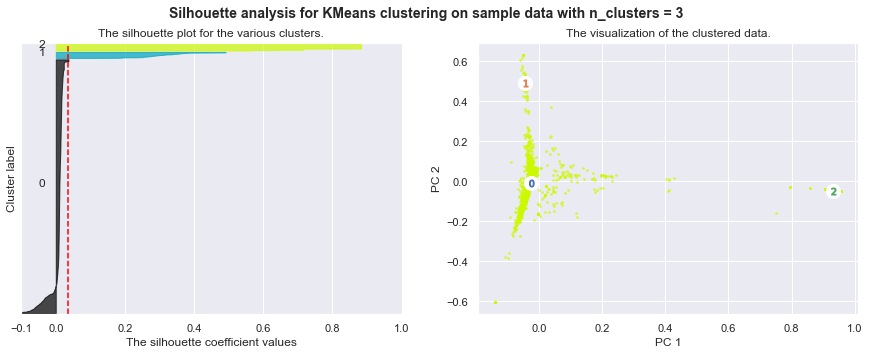

For n_clusters = 3, The average silhouette_score is : 0.034


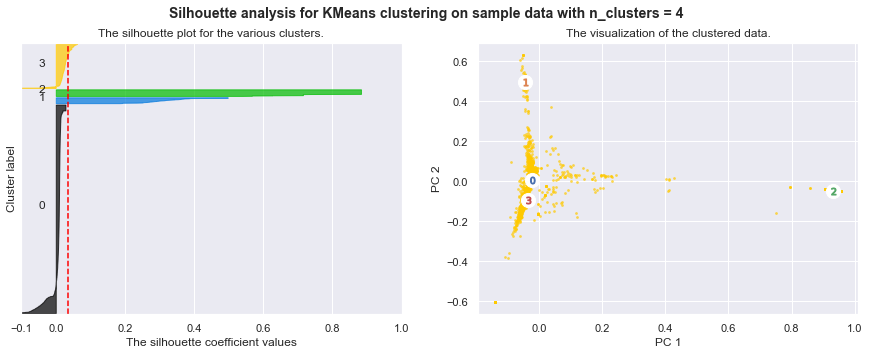

For n_clusters = 4, The average silhouette_score is : 0.035


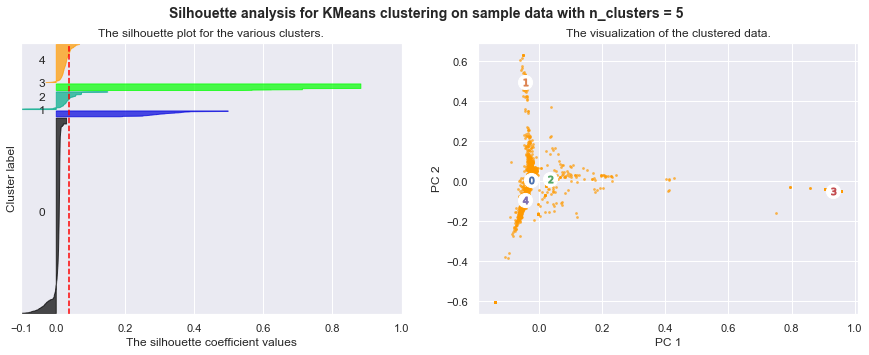

For n_clusters = 5, The average silhouette_score is : 0.037


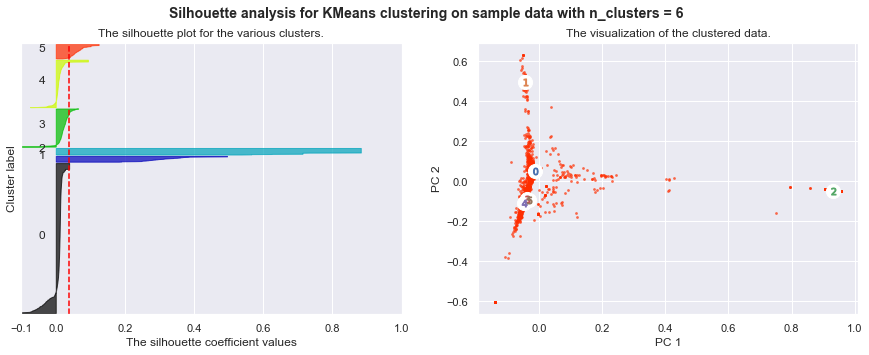

For n_clusters = 6, The average silhouette_score is : 0.039


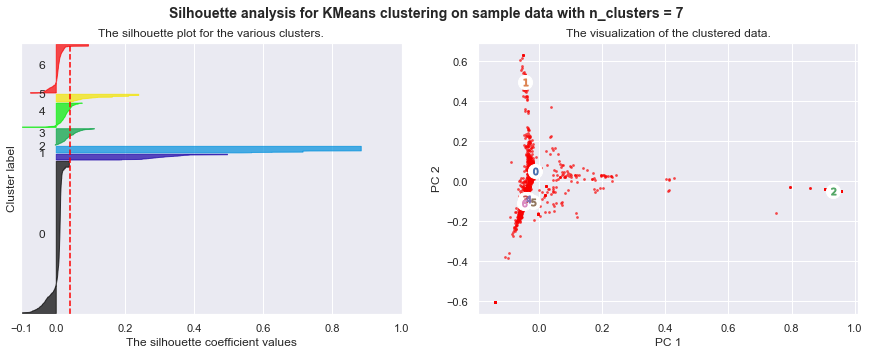

For n_clusters = 7, The average silhouette_score is : 0.040


In [61]:
twtTFVectorizer, twtTFVects = getTFVects(twitter)
for n in cluster_num:
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components=n).fit(twtTFVects.toarray())
    reduced_data = pca.transform(twtTFVects.toarray())
    X = twtTFVects.toarray()
    plotSilhouette_revised(n, X, reduced_data)

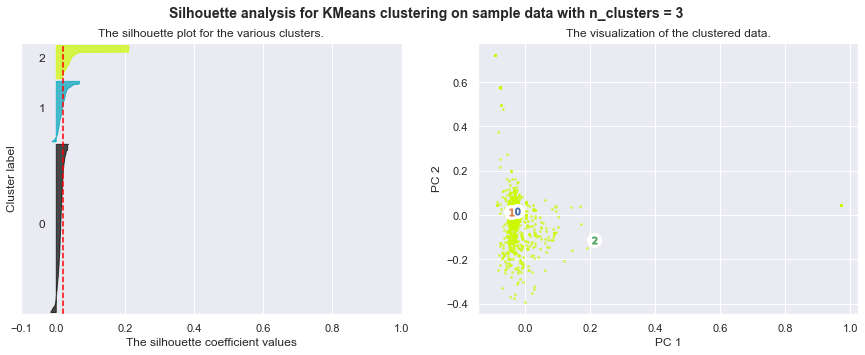

For n_clusters = 3, The average silhouette_score is : 0.021


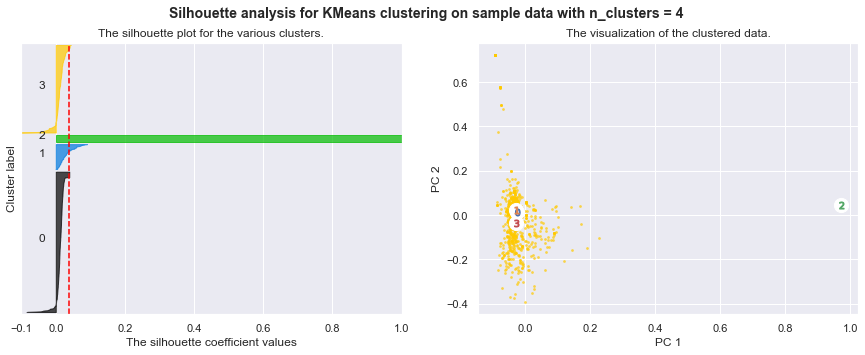

For n_clusters = 4, The average silhouette_score is : 0.039


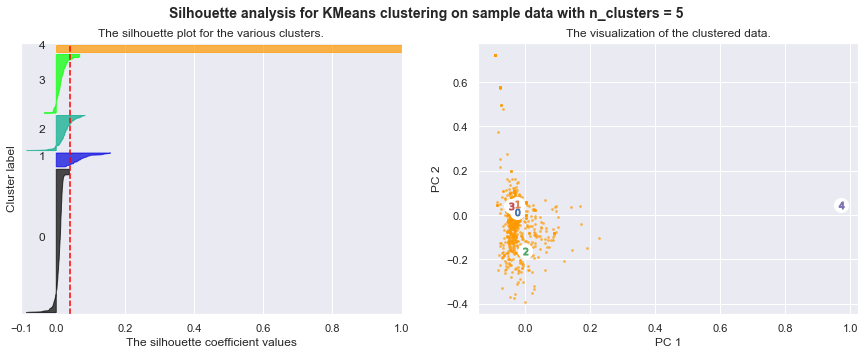

For n_clusters = 5, The average silhouette_score is : 0.042


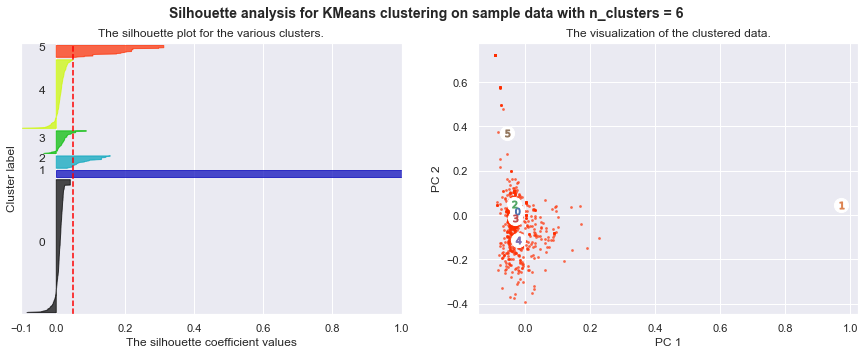

For n_clusters = 6, The average silhouette_score is : 0.050


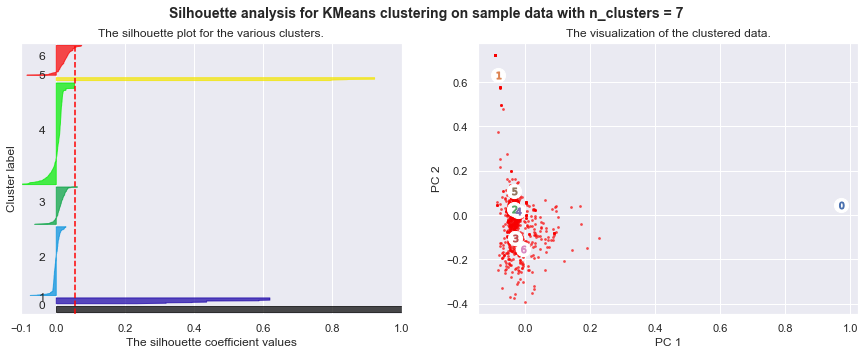

For n_clusters = 7, The average silhouette_score is : 0.055


In [62]:
insTFVectorizer, insTFVects = getTFVects(ins)
for n in cluster_num:
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components=n).fit(insTFVects.toarray())
    reduced_data = pca.transform(insTFVects.toarray())
    X = insTFVects.toarray()
    plotSilhouette_revised(n, X, reduced_data)

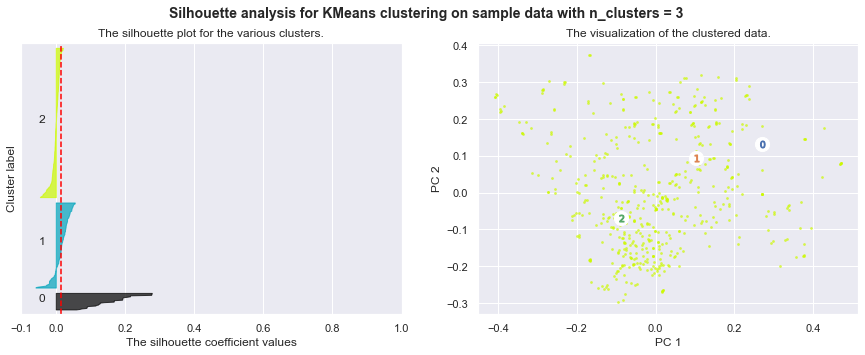

For n_clusters = 3, The average silhouette_score is : 0.015


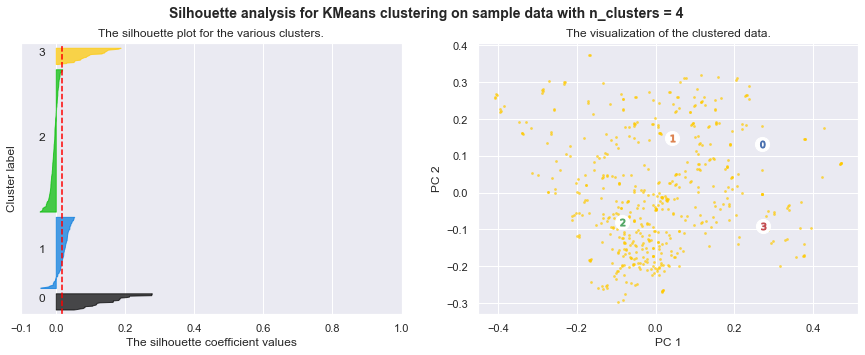

For n_clusters = 4, The average silhouette_score is : 0.019


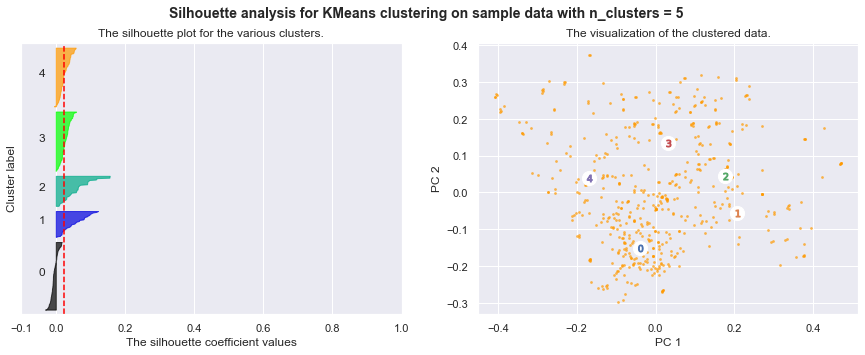

For n_clusters = 5, The average silhouette_score is : 0.025


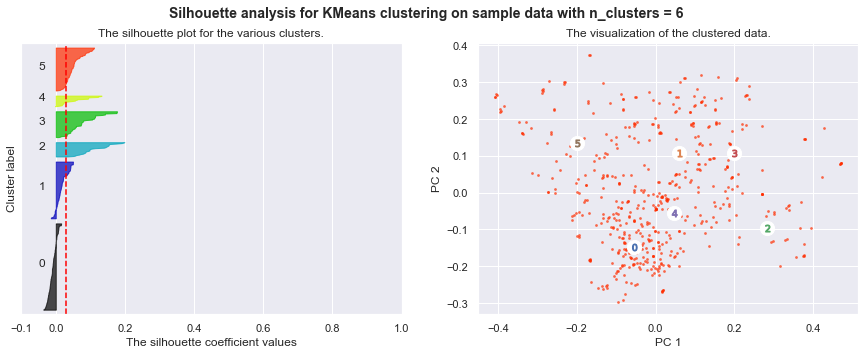

For n_clusters = 6, The average silhouette_score is : 0.028


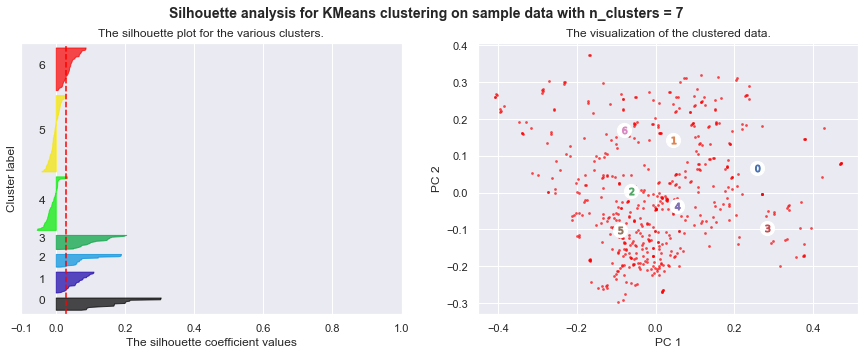

For n_clusters = 7, The average silhouette_score is : 0.030


In [63]:
ytbTFVectorizer, ytbTFVects = getTFVects(youtube)
for n in cluster_num:
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components=n).fit(ytbTFVects.toarray())
    reduced_data = pca.transform(ytbTFVects.toarray())
    X = ytbTFVects.toarray()
    plotSilhouette_revised(n, X, reduced_data)

#### Flat Clustering with $K$-means

In [64]:
colordict = {0: 'plum', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'blue', 5: 'red', 6: 'purple'}
def kMeanClustering(df, n):
    TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.50, max_features=1000, 
                                                           min_df=3, stop_words='english', norm='l2')
    TFVects = TFVectorizer.fit_transform(df['text'])
    km = sklearn.cluster.KMeans(n_clusters=n, init='k-means++')
    km.fit(TFVects.toarray())
    
    print("Evaluations")
    print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(df['text'], km.labels_)))
    print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(df['text'], km.labels_)))
    print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(df['text'], km.labels_)))
    print("Adjusted Rand Score: {:0.3f}\n".format(sklearn.metrics.adjusted_rand_score(df['text'], km.labels_)))
    
    # Distinguish features of the clusters
    print("Top terms per cluster:")
    terms = TFVectorizer.get_feature_names()
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    for i in range(n):
        print("Cluster %d:" % i)
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind])
        print('\n')
    
    df['kmeans_predictions'] = km.labels_
    colors = [colordict[c] for c in df['kmeans_predictions']]
    
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components=n).fit(TFVects.toarray())
    reduced_data = pca.transform(TFVects.toarray())
    components = pca.components_
    keyword_ids = list(set(order_centroids[:,:5].flatten()))
    words = [terms[i] for i in keyword_ids]
    x = components[:,keyword_ids][0,:]
    y = components[:,keyword_ids][1,:]
    
    fig = plt.figure(figsize = (16, 9))
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
    for i, word in enumerate(words):
        ax.annotate(word, (x[i],y[i]))   
    plt.xticks(())
    plt.yticks(())
    plt.title('True Classes')
    plt.show()
    return df

Evaluations
Homogeneity: 0.171
Completeness: 1.000
V-measure: 0.292
Adjusted Rand Score: 0.001

Top terms per cluster:
Cluster 0:
 just
 shoes
 jordan
 pair
 got
 new
 shoe
 today
 collection
 love


Cluster 1:
 air
 max
 force
 jordan
 nike
 90
 1s
 custom
 pair
 high


Cluster 2:
 know
 does
 shoes
 anybody
 buy
 called
 model
 shoe
 kind
 thanks


Cluster 3:
 id
 help
 shoes
 thoughts
 got
 nike
 swap
 sole
 shoe
 flr


Cluster 4:
 help
 identify
 identifying
 shoes
 need
 thanks
 finding
 appreciated
 shoe
 looking


Cluster 5:
 nike
 shoes
 dunk
 low
 sb
 https
 like
 com
 pair
 just




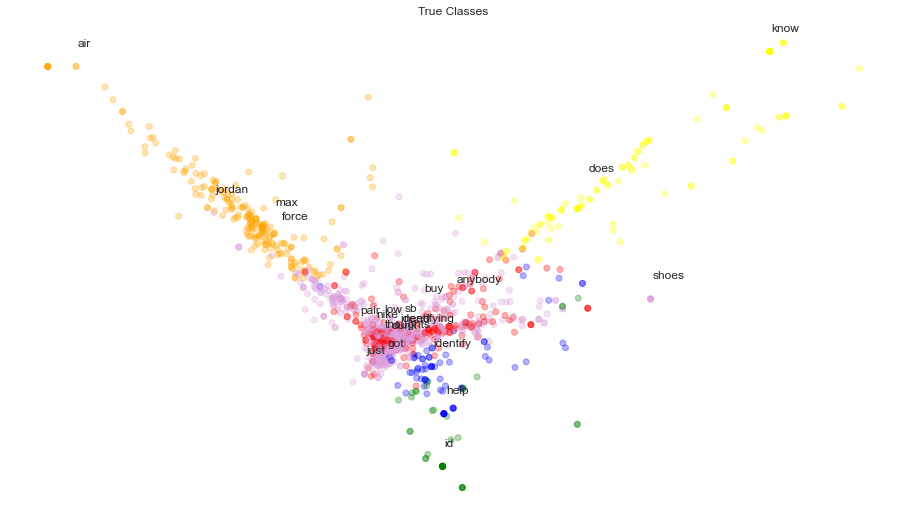

In [65]:
reddit = kMeanClustering(reddit, 6)

Evaluations
Homogeneity: 0.132
Completeness: 1.000
V-measure: 0.233
Adjusted Rand Score: 0.001

Top terms per cluster:
Cluster 0:
 share
 items
 loving
 poshmarkapp
 good
 fashion
 check
 poshmark
 shopmycloset
 style


Cluster 1:
 rt
 just
 dunk
 adidas
 like
 low
 shoes
 kits
 don
 amp


Cluster 2:
 air
 gt
 ad
 jordan
 rt
 max
 force
 white
 black
 eu


Cluster 3:
 cia
 ambasciatausa
 hubby
 marylouzepeda2
 italyinus
 loupinklady
 whitehouse
 boss
 ussupreme_court
 17


Cluster 4:
 new
 chelsea
 kit
 rt
 home
 kits
 adidas
 chelseafc
 just
 shirt


Cluster 5:
 threeuk
 jordyxcollins
 deancarefreecfc
 chelseafc
 dequenoc
 kit
 like
 wow
 nice
 chelseafcw




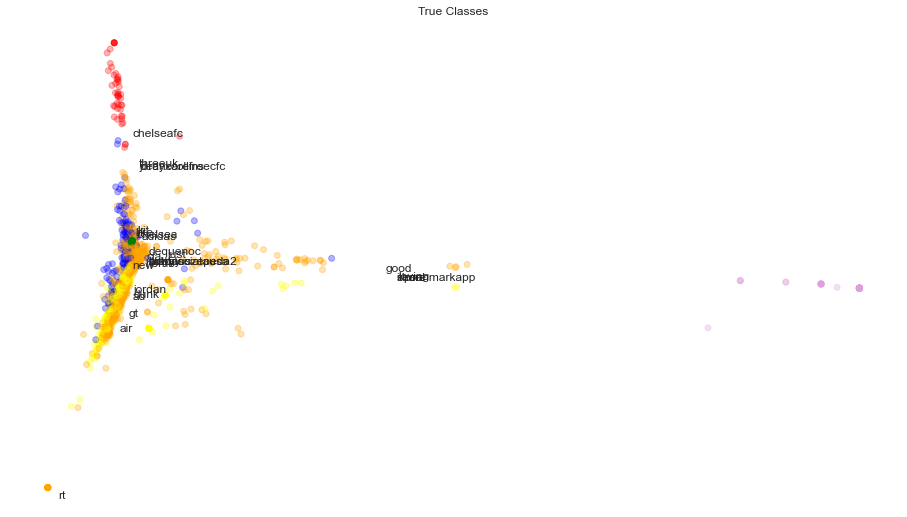

In [66]:
twitter = kMeanClustering(twitter, 6)

Evaluations
Homogeneity: 0.206
Completeness: 1.000
V-measure: 0.342
Adjusted Rand Score: 0.004

Top terms per cluster:
Cluster 0:
 quality
 whatsapp
 price
 best
 products
 bags
 shoes
 selling
 clothes
 contact


Cluster 1:
 adidas
 football
 follow
 like
 fitness
 workout
 gym
 soccer
 sports
 fashion


Cluster 2:
 sneakerhead
 sneakers
 kicks
 kickstagram
 kicksonfire
 jordan
 hypebeast
 nicekicks
 sneakersaddict
 sneakerheads


Cluster 3:
 nikeid
 am1lover
 airmaxnikeairmax1
 soleseriouss
 shamelesskicks
 am1collector
 crepprotect
 kissmyairs
 am1
 footlocker


Cluster 4:
 photooftheday
 instagood
 love
 photography
 fashion
 model
 instagram
 style
 follow
 ootd


Cluster 5:
 jordan
 size
 air
 dm
 new
 available
 brand
 10
 11
 sold




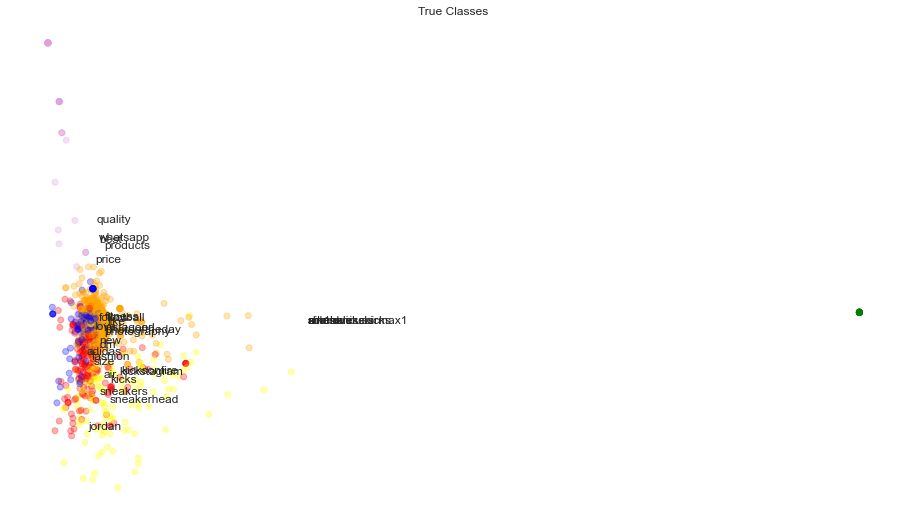

In [67]:
ins = kMeanClustering(ins, 6)

Evaluations
Homogeneity: 0.282
Completeness: 1.000
V-measure: 0.440
Adjusted Rand Score: 0.000

Top terms per cluster:
Cluster 0:
 max
 air
 airmax
 shoe
 90
 98
 plus
 people
 women
 london


Cluster 1:
 shoes
 shoe
 kind
 running
 design
 little
 foam
 feel
 run
 bit


Cluster 2:
 yeah
 gonna
 oh
 okay
 good
 little
 say
 kind
 feel
 people


Cluster 3:
 magista
 bit
 golf
 fit
 layer
 feel
 foot
 little
 actually
 boot


Cluster 4:
 guys
 shoe
 sneaker
 air
 dunk
 sure
 white
 video
 box
 sb


Cluster 5:
 applause
 ball
 way
 sport
 ll
 39
 people
 work
 change
 new


Cluster 6:
 mesh
 lightweight
 features
 shoe
 runs
 design
 fabric
 rubber
 collar
 outsole




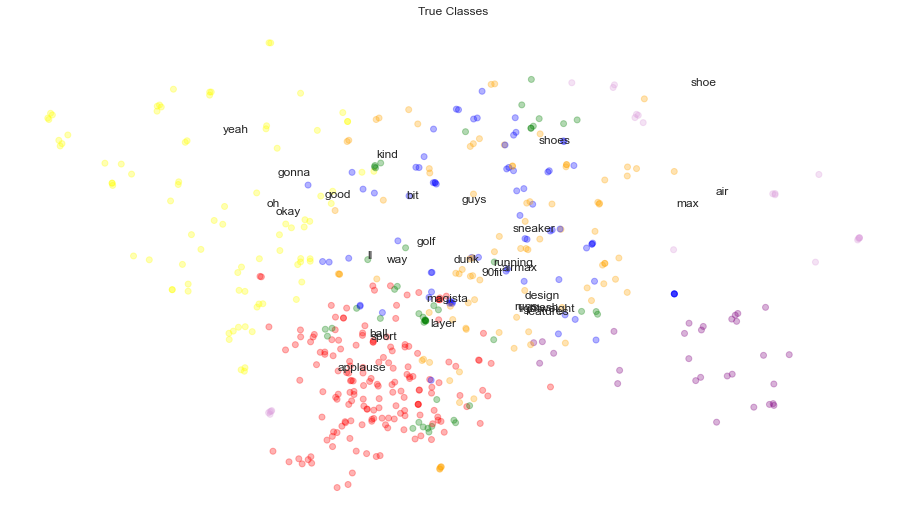

In [68]:
youtube = kMeanClustering(youtube, 7)

#### Hierarchical Cluster

In [69]:
def getLinkageMatrix(TFVects):
    CoocMat = TFVects * TFVects.T
    CoocMat.setdiag(0)
    matrix = scipy.cluster.hierarchy.ward(CoocMat[:50, :50].toarray())
    return matrix

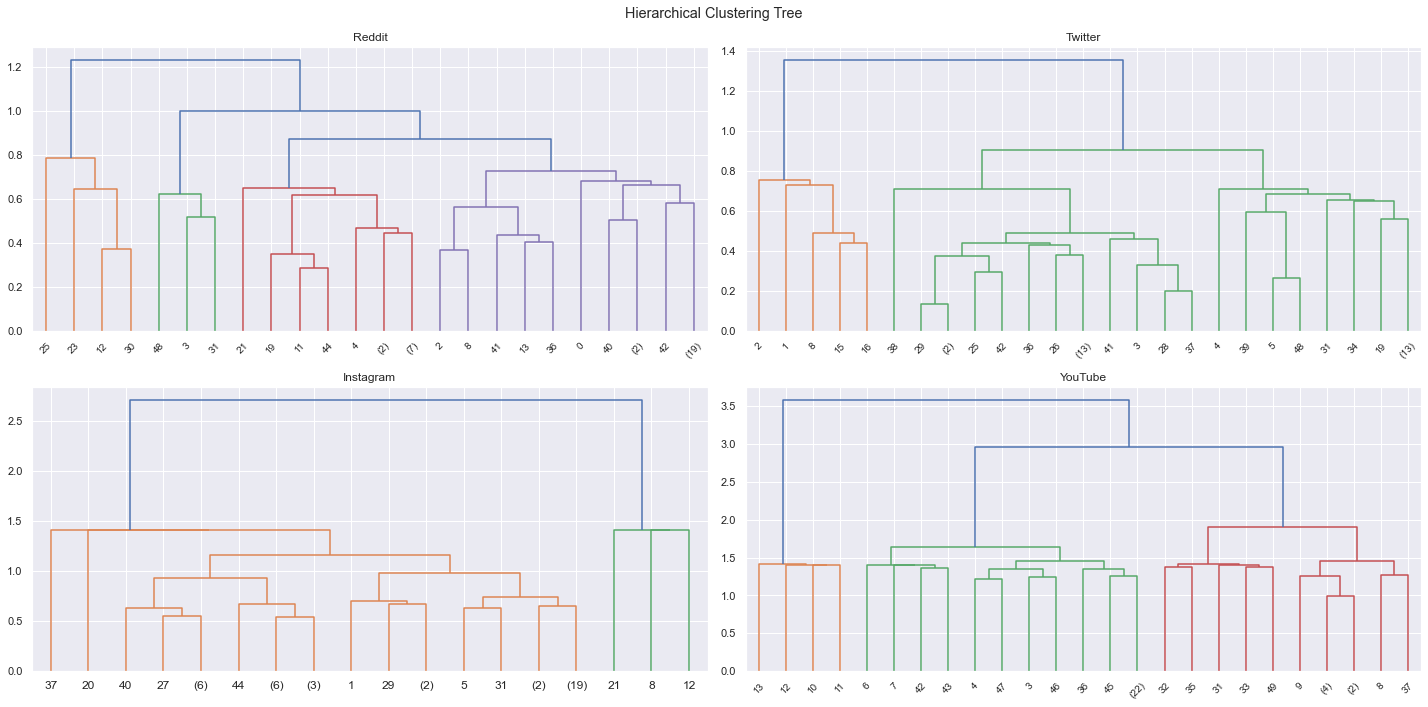

In [70]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle("Hierarchical Clustering Tree")

rdt_matrix = getLinkageMatrix(rdtTFVects)
scipy.cluster.hierarchy.dendrogram(rdt_matrix, p=6, truncate_mode='level', get_leaves=True, ax=axs[0, 0])
axs[0, 0].set_title("Reddit")
twt_matrix = getLinkageMatrix(twtTFVects)
scipy.cluster.hierarchy.dendrogram(twt_matrix, p=6, truncate_mode='level', get_leaves=True, ax=axs[0, 1])
axs[0, 1].set_title("Twitter")

ins_matrix = getLinkageMatrix(insTFVects)
scipy.cluster.hierarchy.dendrogram(ins_matrix, p=6, truncate_mode='level', get_leaves=True, ax=axs[1, 0])
axs[1, 0].set_title("Instagram")
ytb_matrix = getLinkageMatrix(ytbTFVects)
scipy.cluster.hierarchy.dendrogram(ytb_matrix, p=5, truncate_mode='level', get_leaves=True, ax=axs[1, 1])
axs[1, 1].set_title("YouTube")

fig.tight_layout()
plt.show()

In [71]:
def calculateWaldClustering(TFVects, title, n, df):
    CoocMat = TFVects * TFVects.T
    linkage_matrix_full = scipy.cluster.hierarchy.ward(CoocMat.toarray())
    hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, n, 'maxclust')
    print("Silhouetter score for " + title + " is " + 
          str(sklearn.metrics.silhouette_score(CoocMat, hierarchicalClusters_full)))
    df['wald_predictions'] = hierarchicalClusters_full
    return df

In [72]:
reddit = calculateWaldClustering(rdtTFVects, "Reddit", 6, reddit)
twitter = calculateWaldClustering(twtTFVects, "Twitter", 6, twitter)
ins = calculateWaldClustering(insTFVects, "Instagram", 6, ins)
youtube = calculateWaldClustering(ytbTFVects, "YouTube", 6, youtube)

Silhouetter score for Reddit is 0.12894596224654895
Silhouetter score for Twitter is 0.18057300481695407
Silhouetter score for Instagram is 0.11435416936291248
Silhouetter score for YouTube is 0.08750043618545483


#### Genism

In [73]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

reddit['reduced_tokens'] = reddit['normalized_tokens'].apply(lambda x: dropMissing(x, rdtTFVectorizer.vocabulary_.keys()))
twitter['reduced_tokens'] = twitter['normalized_tokens'].apply(lambda x: dropMissing(x, twtTFVectorizer.vocabulary_.keys()))
ins['reduced_tokens'] = ins['normalized_tokens'].apply(lambda x: dropMissing(x, insTFVectorizer.vocabulary_.keys()))
youtube['reduced_tokens'] = youtube['normalized_tokens'].apply(lambda x: dropMissing(x, ytbTFVectorizer.vocabulary_.keys()))

In [74]:
def conductLDAModel(df, title):
    dictionary = gensim.corpora.Dictionary(df['reduced_tokens'])
    corpus = [dictionary.doc2bow(text) for text in df['reduced_tokens']]
    gensim.corpora.MmCorpus.serialize(title, corpus)
    mmcorpus = gensim.corpora.MmCorpus(title)
    lda = gensim.models.ldamodel.LdaModel(corpus=mmcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')
    return dictionary, lda

In [75]:
rdt_dict, rdt_lda = conductLDAModel(reddit, "Reddit")
twt_dict, twt_lda = conductLDAModel(twitter, "Twitter")
ins_dict, ins_lda = conductLDAModel(ins, "Instagram")
ytb_dict, ytb_lda = conductLDAModel(youtube, "YouTube")

#### Reddit

In [76]:
rdt_ldaDF = pd.DataFrame({'upvotes' : reddit['upvotes'], 
                         'topics' : [rdt_lda[rdt_dict.doc2bow(l)] for l in reddit['reduced_tokens']]})
topicsProbDict = {i : [0] * len(rdt_ldaDF) for i in range(rdt_lda.num_topics)}

for index, topicTuples in enumerate(rdt_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

for topicNum in range(rdt_lda.num_topics):
    rdt_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

rdt_ldaDF.head()

,upvotes,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,1,"[(1, 0.9462975)]",0.000000,0.946298,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,"[(6, 0.3085273), (8, 0.6252199)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.308527,0.000000,0.625220,0.000000
3,2,"[(0, 0.015030425), (1, 0.8643681), (2, 0.01484...",0.015030,0.864368,0.014847,0.014768,0.016149,0.014434,0.014713,0.015426,0.015318,0.014946
4,6,"[(0, 0.022739105), (1, 0.025430935), (2, 0.022...",0.022739,0.025431,0.022461,0.022343,0.024434,0.021836,0.791636,0.023334,0.023176,0.022609
5,1,"[(1, 0.011141546), (4, 0.010706303), (7, 0.010...",0.000000,0.011142,0.000000,0.000000,0.010706,0.000000,0.000000,0.010225,0.010154,0.908858


In [77]:
rdt_ldaDF.sort_values(by=['upvotes'], ascending=False, inplace=True)
rdt_ldaDFV = rdt_ldaDF[:10][['topic_%d' %x for x in range(10)]]
rdt_ldaDFVisN = rdt_ldaDF[:10][['upvotes']]
rdt_ldaDFVis = rdt_ldaDFV.values
rdt_ldaDFVisNames = rdt_ldaDFVisN.values

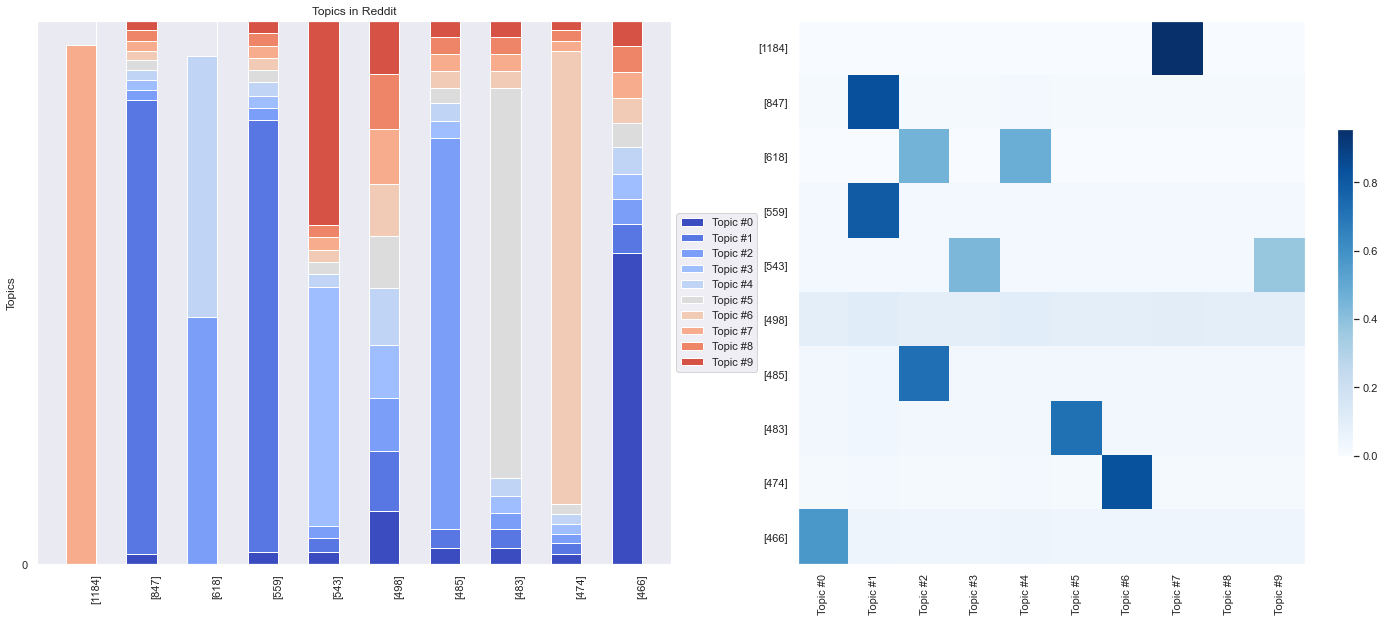

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = rdt_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, rdt_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, rdt_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += rdt_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "Reddit")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(rdt_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(rdt_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(rdt_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(rdt_ldaDFVisNames);
ax2.set_xticks(np.arange(rdt_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(rdt_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

In [79]:
topicsDict = {}
for topicNum in range(rdt_lda.num_topics):
    topicWords = [w for w, p in rdt_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,nike,nike,pair,air,nike,nike,air,nike,size,nike
1,air,air,nike,nike,got,came,jordan,got,air,buy
2,jordan,pair,jordan,max,pair,drop,shoe,jordan,nike,dunk
3,max,like,like,jordan,air,jordan,pair,help,force,release
4,red,help,air,days,help,think,ve,like,pair,custom
5,help,max,nikes,think,shoe,pick,max,shorts,shoe,new
6,ve,new,today,app,new,today,finally,want,bought,called
7,pair,buy,time,force,jordan,time,nike,way,like,high
8,black,white,new,low,site,snkrs,time,size,buy,shoe
9,support,love,app,mail,identify,got,thanks,buy,new,jordan


In [80]:
rdt_ldaDFV = rdt_ldaDF[-10:][['topic_%d' %x for x in range(10)]]
rdt_ldaDFVisN = rdt_ldaDF[-10:][['upvotes']]
rdt_ldaDFVis = rdt_ldaDFV.values
rdt_ldaDFVisNames = rdt_ldaDFVisN.values

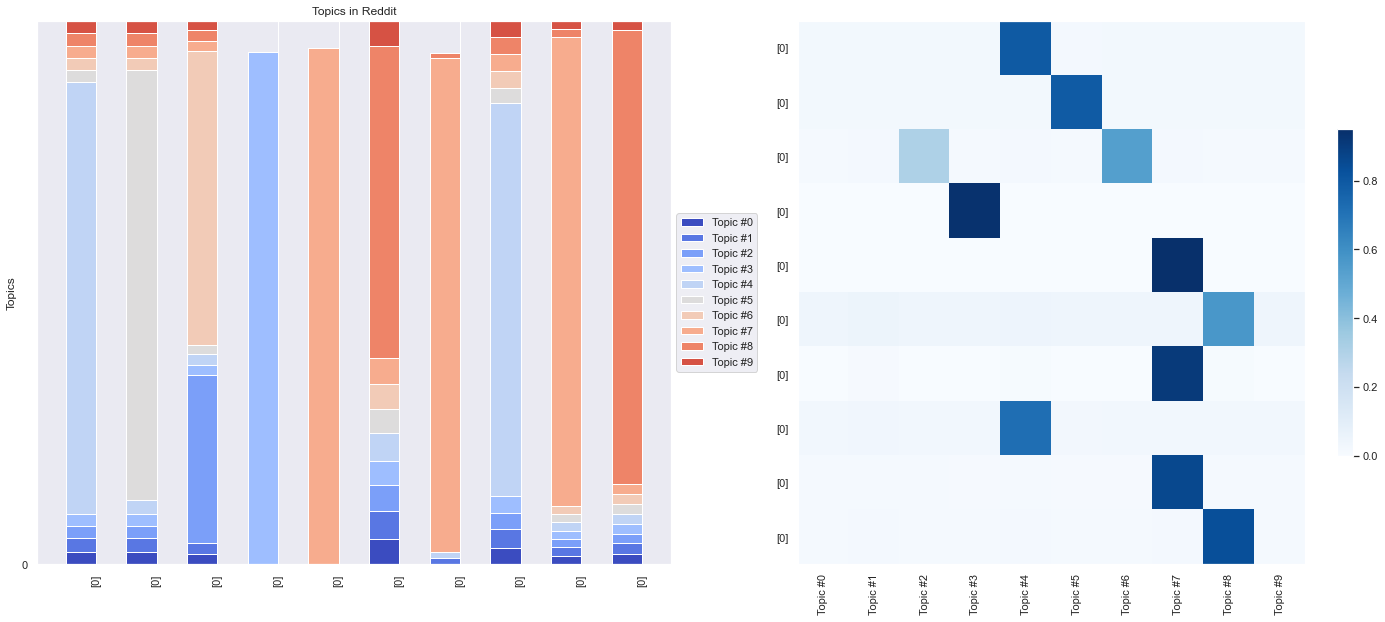

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = rdt_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, rdt_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, rdt_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += rdt_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "Reddit")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(rdt_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(rdt_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(rdt_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(rdt_ldaDFVisNames);
ax2.set_xticks(np.arange(rdt_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(rdt_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

#### Twitter

In [82]:
twt_ldaDF = pd.DataFrame({'favorite_cnt' : twitter['favorite_cnt'],
                         'topics' : [twt_lda[twt_dict.doc2bow(l)] for l in twitter['reduced_tokens']]})
topicsProbDict = {i : [0] * len(twt_ldaDF) for i in range(twt_lda.num_topics)}

for index, topicTuples in enumerate(twt_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

for topicNum in range(twt_lda.num_topics):
    twt_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

twt_ldaDF.head()

,favorite_cnt,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0,"[(0, 0.021029884), (1, 0.026640324), (2, 0.022...",0.021030,0.026640,0.022621,0.022804,0.022102,0.021974,0.022379,0.020417,0.798725,0.021308
2,0,"[(0, 0.021019785), (1, 0.026631007), (2, 0.022...",0.021020,0.026631,0.022611,0.022792,0.022091,0.021965,0.799133,0.020407,0.022053,0.021297
3,0,"[(0, 0.021022087), (1, 0.8033696), (2, 0.02261...",0.021022,0.803370,0.022613,0.022795,0.022095,0.021967,0.022371,0.020410,0.022056,0.021301
4,0,"[(0, 0.01183745), (1, 0.0149973435), (2, 0.012...",0.011837,0.014997,0.012733,0.342696,0.353727,0.012370,0.012598,0.011492,0.012420,0.215129
5,0,"[(0, 0.021020418), (1, 0.0266245), (2, 0.02261...",0.021020,0.026625,0.022611,0.022793,0.022092,0.021965,0.022369,0.020408,0.304076,0.516041


In [83]:
twt_ldaDF.sort_values(by=['favorite_cnt'], ascending=False, inplace=True)
twt_ldaDFV = twt_ldaDF[:10][['topic_%d' %x for x in range(10)]]
twt_ldaDFVisN = twt_ldaDF[:10][['favorite_cnt']]
twt_ldaDFVis = twt_ldaDFV.values
twt_ldaDFVisNames = twt_ldaDFVisN.values

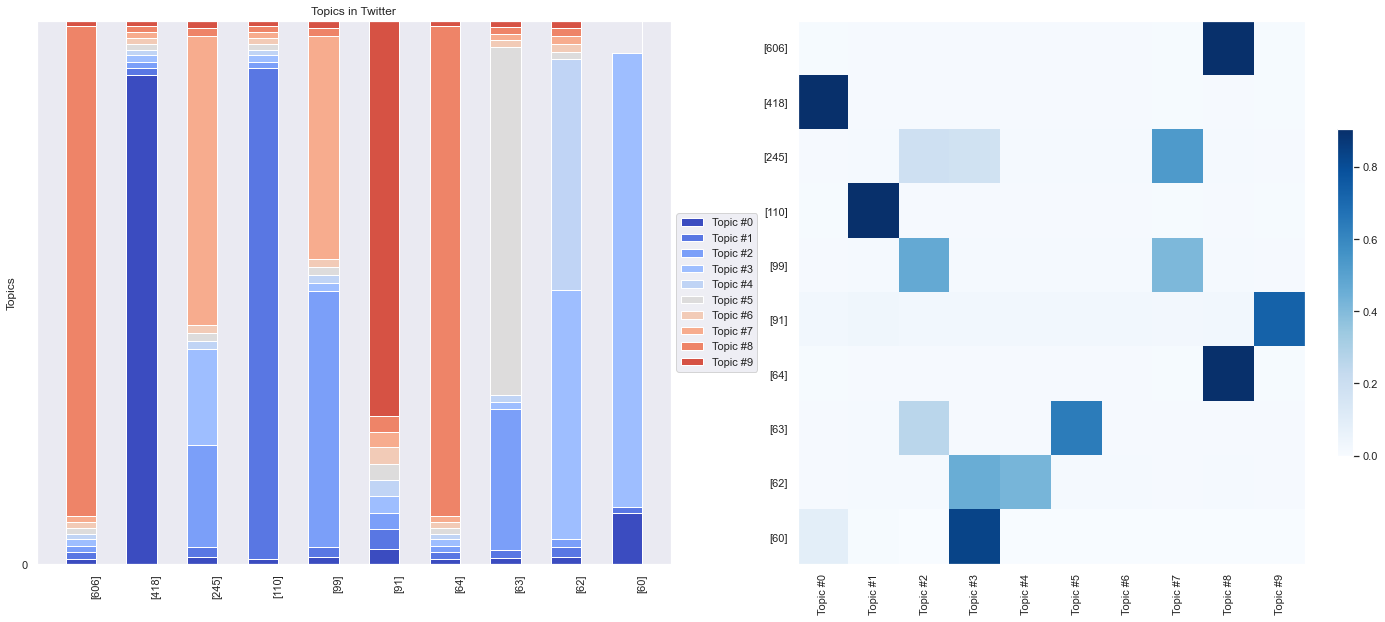

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = twt_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, twt_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, twt_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += twt_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "Twitter")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(twt_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(twt_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(twt_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(twt_ldaDFVisNames);
ax2.set_xticks(np.arange(twt_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(twt_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

In [85]:
topicsDict = {}
for topicNum in range(twt_lda.num_topics):
    topicWords = [w for w, p in twt_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,today,eu,promo,kickz,doge,air,white,love,color,swoosh
1,proper,playstation,whatsapp,new,low,following,mini,nice,zoom,draw
2,register,gt,phone,sur,dunk,sneakers,light,looking,sponsored,snkrs
3,purchase,ad,telegram,playstation,black,playstation,air,like,air,ad
4,new,pg,discount,low,got,check,style,man,relationship,louies
5,gt,live,trainers,pg,green,blue,mens,feel,got,gt
6,shirt,air,kits,adidas,great,force,force,right,max,hall
7,got,size,check,pg5,sb,price,blazer,visit,black,vote
8,football,jordan,sb,boss,logo,morning,use,saying,watch,week
9,summer,link,pls,cia,employees,hate,saturday,add,women,fame


In [86]:
twt_ldaDFV = twt_ldaDF[-10:][['topic_%d' %x for x in range(10)]]
twt_ldaDFVisN = twt_ldaDF[-10:][['favorite_cnt']]
twt_ldaDFVis = twt_ldaDFV.values
twt_ldaDFVisNames = twt_ldaDFVisN.values

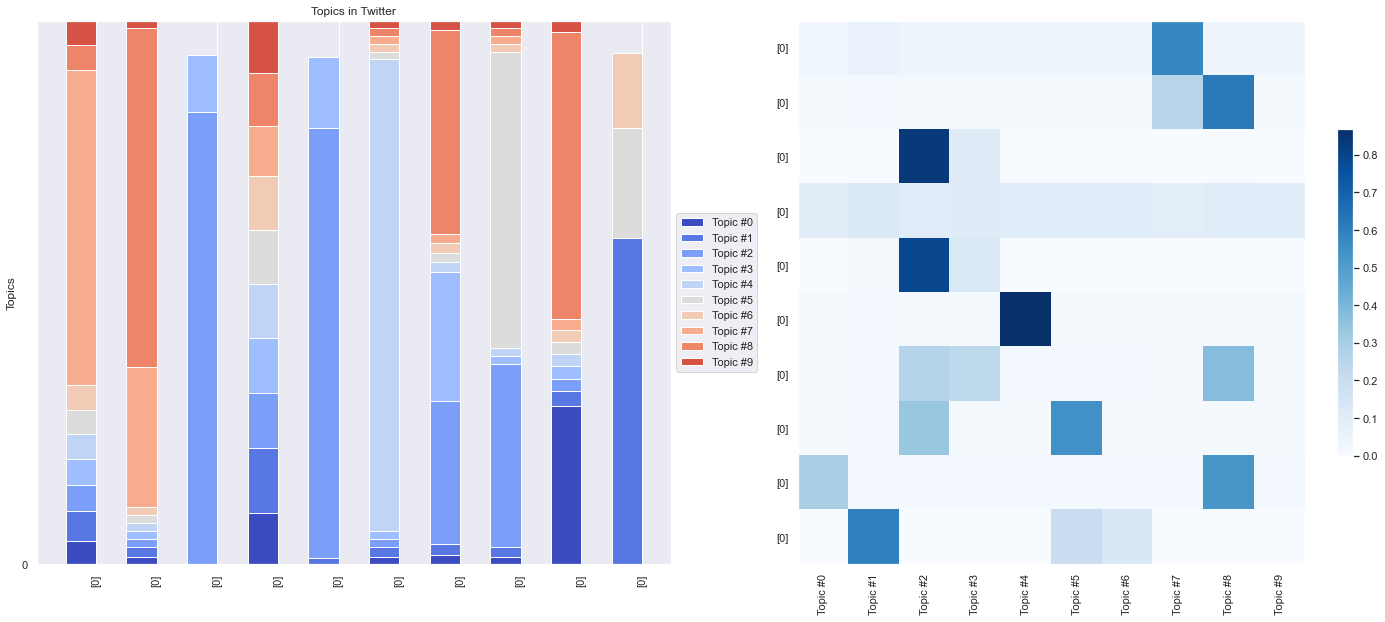

In [87]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = twt_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, twt_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, twt_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += twt_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "Twitter")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(twt_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(twt_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(twt_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(twt_ldaDFVisNames);
ax2.set_xticks(np.arange(twt_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(twt_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

#### Instagram

In [88]:
ins_ldaDF = pd.DataFrame({'likes' : ins['likes'],
                         'topics' : [ins_lda[ins_dict.doc2bow(l)] for l in ins['reduced_tokens']]})
topicsProbDict = {i : [0] * len(ins_ldaDF) for i in range(ins_lda.num_topics)}

for index, topicTuples in enumerate(ins_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

for topicNum in range(ins_lda.num_topics):
    ins_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ins_ldaDF.head()

,likes,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,480,"[(0, 0.011769994), (1, 0.011376843), (2, 0.011...",0.011770,0.011377,0.011808,0.888789,0.013044,0.012633,0.012464,0.011695,0.013310,0.013109
1,489,"[(1, 0.36320025), (6, 0.5875763)]",0.000000,0.363200,0.000000,0.000000,0.000000,0.000000,0.587576,0.000000,0.000000,0.000000
2,869,"[(3, 0.37487411), (5, 0.5825398)]",0.000000,0.000000,0.000000,0.374874,0.000000,0.582540,0.000000,0.000000,0.000000,0.000000
3,3022,"[(0, 0.020954393), (1, 0.020254336), (2, 0.021...",0.020954,0.020254,0.021023,0.326500,0.023224,0.497995,0.022191,0.020822,0.023698,0.023339
4,259,"[(6, 0.9520796)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.952080,0.000000,0.000000,0.000000


In [89]:
ins_ldaDF.dropna(subset=['likes'], inplace=True)
ins_ldaDF = ins_ldaDF[ins_ldaDF.likes.str.isnumeric()]
ins_ldaDF["likes"] = ins_ldaDF["likes"].astype(str).astype(int)

In [90]:
ins_ldaDF.sort_values(by=['likes'], ascending=False, inplace=True)
ins_ldaDFV = ins_ldaDF[:10][['topic_%d' %x for x in range(10)]]
ins_ldaDFVisN = ins_ldaDF[:10][['likes']]
ins_ldaDFVis = ins_ldaDFV.values
ins_ldaDFVisNames = ins_ldaDFVisN.values

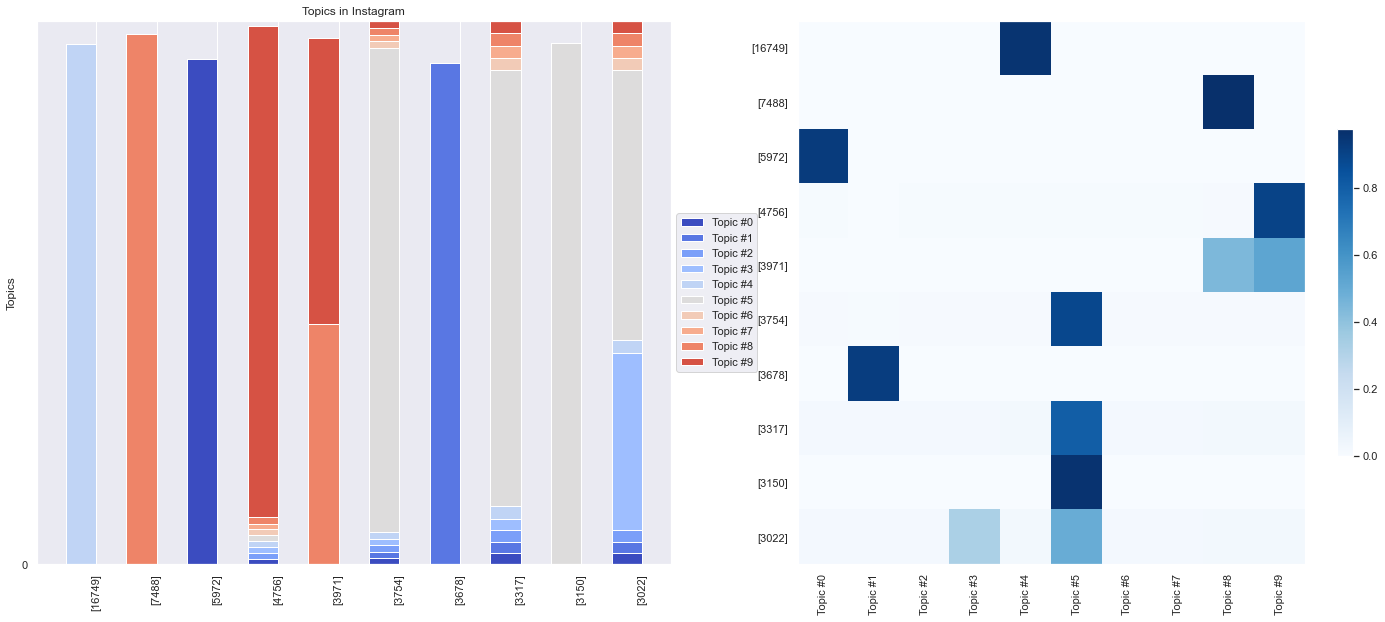

In [91]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = ins_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, ins_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, ins_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ins_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "Instagram")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(ins_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(ins_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(ins_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(ins_ldaDFVisNames);
ax2.set_xticks(np.arange(ins_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(ins_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

In [92]:
topicsDict = {}
for topicNum in range(ins_lda.num_topics):
    topicWords = [w for w, p in ins_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,adidas,dunk,love,jordan,jordan,jordan,follow,jordan,jordan,jordan
1,airforce1,jordan,sneakers,instagram,best,size,fashion,eyes,fashion,airmax
2,follow,sz,fashion,follow,sneakers,new,sneakers,model,adidas,fitness
3,puma,sb,sneakerhead,running,price,air,instagood,throwback,style,nba
4,football,air,sneaker,sneakers,quality,brand,love,all_shots,yeezy,jumpman23
5,size,new,adidas,like,like,sneakerhead,adidas,instagramhub,sneakers,sneakernews
6,available,low,photooftheday,adidas,football,dm,photooftheday,look,sneakerhead,sneakers
7,bio,dm,follow,dm,air,sneakers,hypebeast,jj,link,airmax1
8,air,size,streetwear,content,adidas,kicksonfire,style,harrystyles,bio,footlocker
9,link,sneakers,jordan,run,bags,sold,instagram,nice,quality,air


In [93]:
ins_ldaDFV = ins_ldaDF[-10:][['topic_%d' %x for x in range(10)]]
ins_ldaDFVisN = ins_ldaDF[-10:][['likes']]
ins_ldaDFVis = ins_ldaDFV.values
ins_ldaDFVisNames = ins_ldaDFVisN.values

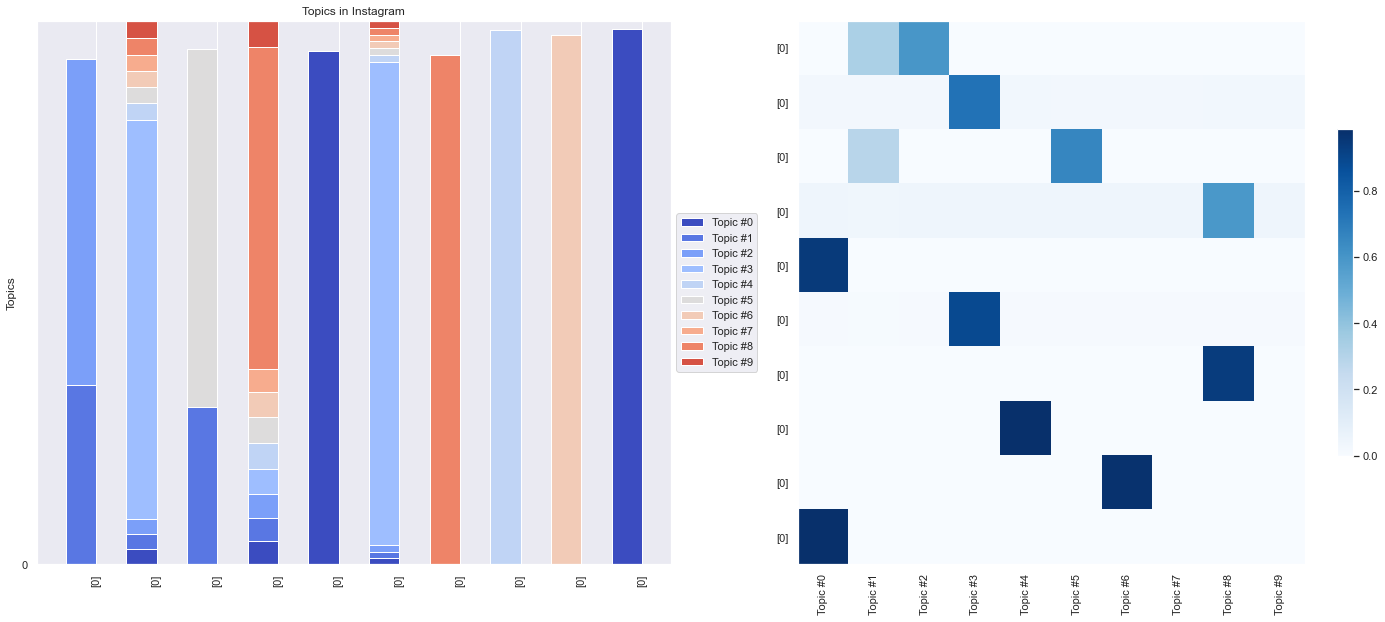

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = ins_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, ins_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, ins_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ins_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "Instagram")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(ins_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(ins_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(ins_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(ins_ldaDFVisNames);
ax2.set_xticks(np.arange(ins_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(ins_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

#### YouTube

In [95]:
ytb_ldaDF = pd.DataFrame({'likeCount' : youtube['likeCount'],
                         'topics' : [ytb_lda[ytb_dict.doc2bow(l)] for l in youtube['reduced_tokens']]})
topicsProbDict = {i : [0] * len(ytb_ldaDF) for i in range(ytb_lda.num_topics)}

for index, topicTuples in enumerate(ytb_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

for topicNum in range(ytb_lda.num_topics):
    ytb_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ytb_ldaDF.head()

,likeCount,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,3031,"[(0, 0.012040386), (1, 0.010850519), (3, 0.901...",0.01204,0.010851,0.0,0.901742,0.012239,0.011320,0.011105,0.010721,0.010876,0.0
1,106964,"[(1, 0.9283949)]",0.00000,0.928395,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,13094,"[(5, 0.9238331), (6, 0.06847507)]",0.00000,0.000000,0.0,0.000000,0.000000,0.923833,0.068475,0.000000,0.000000,0.0
3,42217,"[(8, 0.9433252)]",0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.943325,0.0
4,40967,"[(8, 0.9433202)]",0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.943320,0.0


In [96]:
ytb_ldaDF = ytb_ldaDF[ytb_ldaDF.likeCount.str.isnumeric()]
ytb_ldaDF["likeCount"] = ytb_ldaDF["likeCount"].astype(str).astype(int)

In [97]:
ytb_ldaDF.sort_values(by=['likeCount'], ascending=False, inplace=True)
ytb_ldaDFV = ytb_ldaDF[:10][['topic_%d' %x for x in range(10)]]
ytb_ldaDFVisN = ytb_ldaDF[:10][['likeCount']]
ytb_ldaDFVis = ytb_ldaDFV.values
ytb_ldaDFVisNames = ytb_ldaDFVisN.values

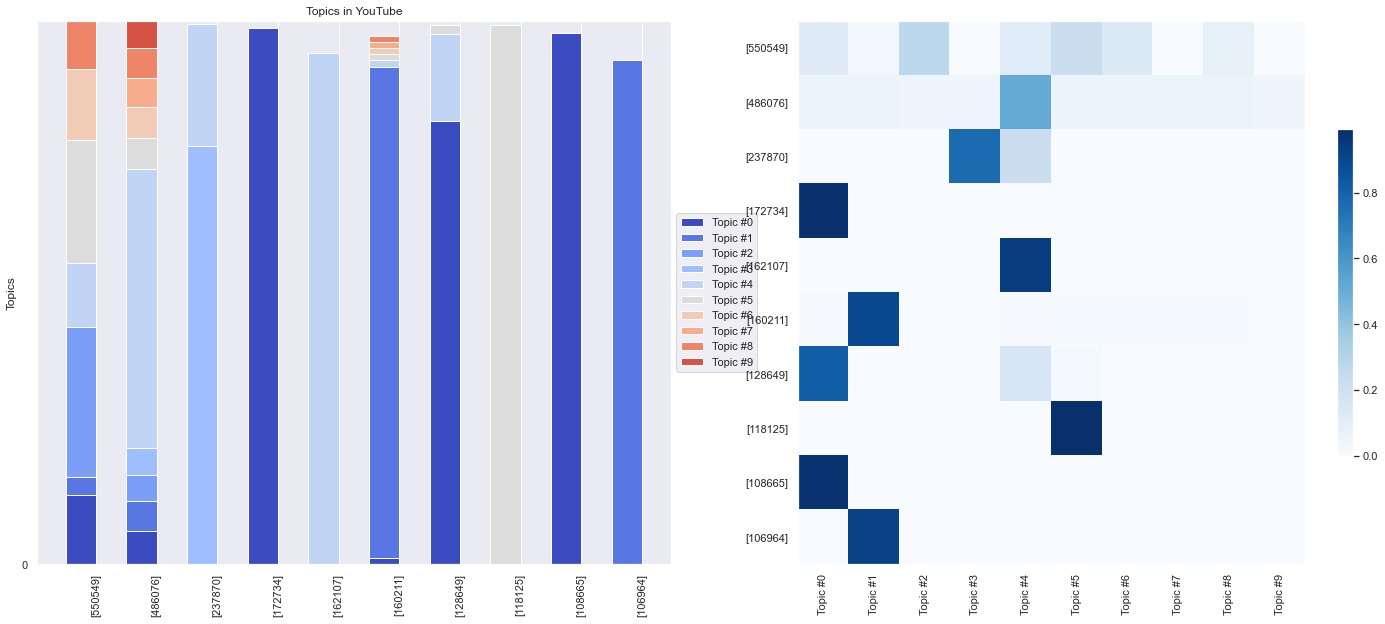

In [98]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = ytb_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, ytb_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, ytb_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ytb_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "YouTube")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(ytb_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(ytb_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(ytb_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(ytb_ldaDFVisNames);
ax2.set_xticks(np.arange(ytb_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(ytb_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

In [99]:
topicsDict = {}
for topicNum in range(ytb_lda.num_topics):
    topicWords = [w for w, p in ytb_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,new,sure,max,good,air,kind,air,bit,guys,feel
1,little,actually,air,little,good,air,people,feel,little,little
2,people,little,feel,okay,yeah,people,max,little,feel,bit
3,thing,look,little,yeah,actually,little,look,lot,lot,lot
4,look,lot,actually,lot,little,look,lot,look,running,yeah
5,way,good,bit,way,look,lot,stitch,people,look,kind
6,kind,way,kind,look,guys,good,kind,actually,good,look
7,feel,kind,video,oh,kind,thing,way,uh,bit,good
8,lot,yeah,lot,feel,lot,max,little,kind,air,great
9,bit,guys,uh,kind,way,actually,crochet,way,actually,love


In [100]:
ytb_ldaDFV = ytb_ldaDF[-10:][['topic_%d' %x for x in range(10)]]
ytb_ldaDFVisN = ytb_ldaDF[-10:][['likeCount']]
ytb_ldaDFVis = ytb_ldaDFV.values
ytb_ldaDFVisNames = ytb_ldaDFVisN.values

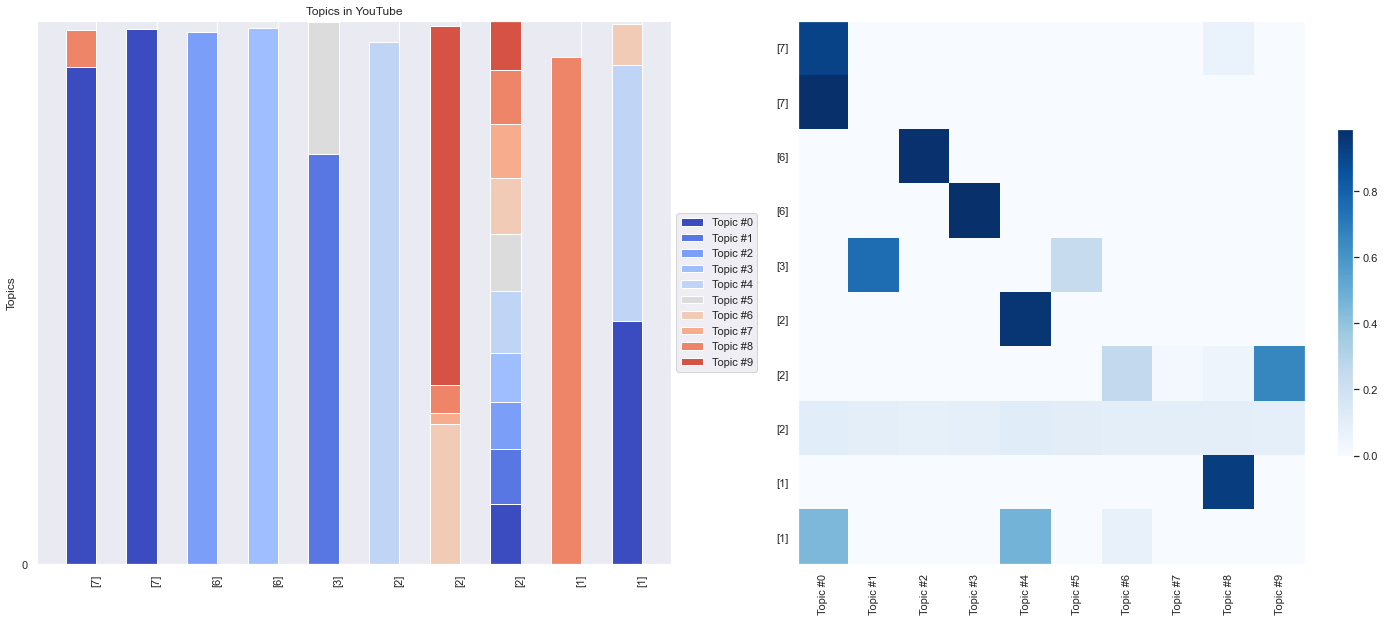

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = ytb_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, ytb_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, ytb_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ytb_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "YouTube")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(ytb_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(ytb_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(ytb_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(ytb_ldaDFVisNames);
ax2.set_xticks(np.arange(ytb_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(ytb_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

#### NLTK Topic Modeling

In [102]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}

    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

def get_lemmas(text):
    stop = nltk.corpus.stopwords.words('english') + list(string.punctuation)
    tokens = [i for i in nltk.word_tokenize(text.lower()) if i not in stop]
    lemmas = [nltk.stem.WordNetLemmatizer().lemmatize(t, get_wordnet_pos(t)) for t in tokens]
    return lemmas

def make_bigrams(lemmas, min_count=5):
    bigram = models.Phrases(lemmas, min_count)
    bigram_mod = models.phrases.Phraser(bigram)
    return [bigram_mod[doc] for doc in lemmas]

def make_bag_words(lemmas):
    dictionary = corpora.Dictionary([i for i in lemmas])
    bow_corpus = [dictionary.doc2bow(text) for text in lemmas]
    return dictionary, bow_corpus

In [103]:
def nltkTopicModeling(df_list, title_list, num_topics=3, num_words=20):
    for i in range(len(df_list)):
        print("Topic Modeling for " + title_list[i])
        text = df_list[i].text.apply(get_lemmas)
        dic, bow = make_bag_words(make_bigrams(text))
        model = models.ldamodel.LdaModel(bow, num_topics=num_topics, id2word=dic, passes=20, iterations=400)
        print(model.print_topics(num_words=num_words))
        print("\n")

In [104]:
nltkTopicModeling(df_lst, title_lst)

Topic Modeling for Reddit
[(0, '0.033*"’" + 0.017*"nike" + 0.008*"”" + 0.008*"“" + 0.007*"jordan" + 0.007*"look" + 0.006*"1" + 0.006*"jordan_1" + 0.005*"name" + 0.005*"call" + 0.005*"get" + 0.005*"like" + 0.005*"x" + 0.005*"anyone" + 0.004*"want" + 0.004*"low" + 0.004*"af1" + 0.004*"come" + 0.004*"short" + 0.004*"year"'), (1, '0.029*"nike" + 0.015*"size" + 0.013*"\'s" + 0.011*"pair" + 0.010*"shoe" + 0.008*"make" + 0.007*"1" + 0.007*"http" + 0.006*"like" + 0.006*"buy" + 0.006*"new" + 0.006*"get" + 0.006*"\'m" + 0.005*"look" + 0.005*"``" + 0.004*"air_max" + 0.004*"air_jordan" + 0.004*"want" + 0.004*"\'\'" + 0.004*"find"'), (2, '0.033*"’" + 0.029*"shoe" + 0.027*"nike" + 0.019*"get" + 0.010*"anyone_know" + 0.009*"pair" + 0.007*"one" + 0.007*"air_max" + 0.007*"new" + 0.006*"look" + 0.006*"find" + 0.006*"go" + 0.005*"day" + 0.005*"anyone" + 0.005*"make" + 0.005*"custom" + 0.005*"air_force" + 0.005*"help" + 0.005*"1" + 0.004*"think"')]


Topic Modeling for Twitter
[(0, '0.078*"nike" + 0.019*"